In [4]:
import pandas as pd
import numpy as np

# === 1. Load Dataset ===
df = pd.read_excel("data.xlsx")

# === 2. Clean Data ===
# Replace "-" with NaN
df = df.replace("-", np.nan)

# Drop duplicate rows if any
df = df.drop_duplicates()

# Print dataset shape
print(f"Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")

# === 3. Convert Numeric Columns ===
for col in df.columns:
    # Try converting each column to numeric if possible
    df[col] = pd.to_numeric(df[col], errors='ignore')

# === 4. Missing Value Analysis ===
missing_info = df.isna().sum().to_frame(name='MissingCount')
missing_info['MissingPercent'] = (missing_info['MissingCount'] / len(df)) * 100
missing_info = missing_info.sort_values(by='MissingPercent', ascending=False)

# Identify features to drop, impute, or keep
drop_features = missing_info[missing_info['MissingPercent'] > 60].index.tolist()
impute_features = missing_info[(missing_info['MissingPercent'] <= 60) & 
                               (missing_info['MissingPercent'] > 0)].index.tolist()
complete_features = missing_info[missing_info['MissingPercent'] == 0].index.tolist()

print("\n=== Missing Value Report ===")
print(missing_info)

print("\nDrop these features (>60% missing):")
print(drop_features)

print("\nImpute these features (<=60% missing):")
print(impute_features)

print("\nNo missing values:")
print(complete_features)

# === 5. Save Cleaned Dataset (Optional) ===
df.to_csv("groundwater_cleaned.csv", index=False)
print("\nCleaned dataset saved as groundwater_cleaned.csv")


C:\Users\ABCD\AppData\Local\Temp\ipykernel_12620\897344084.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace("-", np.nan)
C:\Users\ABCD\AppData\Local\Temp\ipykernel_12620\897344084.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


Dataset Shape: 16776 rows × 24 columns

=== Missing Value Report ===
                MissingCount  MissingPercent
As (ppb)                9702       57.832618
Fe (ppm)                8941       53.296376
PO4                     8151       48.587268
U (ppb)                 5331       31.777539
K (mg/L)                1519        9.054602
pH                      1518        9.048641
EC (µS/cm at            1517        9.042680
HCO3                    1517        9.042680
NO3                     1517        9.042680
SO4                     1517        9.042680
F (mg/L)                1517        9.042680
Cl (mg/L)               1517        9.042680
Na (mg/L)               1517        9.042680
Mg (mg/L)               1517        9.042680
Ca (mg/L)               1517        9.042680
CO3 (mg/L)              1517        9.042680
Total Hardness          1517        9.042680
Location                  31        0.184788
Latitude                   3        0.017883
Longitude                  2   

In [ ]:
pip install pandas numpy scikit-learn joblib


: 

In [8]:
import pandas as pd
import numpy as np
import re

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GroupKFold

# =========================
# 1. Load Dataset
# =========================
df = pd.read_csv("groundwater_cleaned.csv")

# Replace problematic entries
df.replace(["–", "BDL", "#REF!", "NA", "N/A"], np.nan, inplace=True)

# Drop duplicates
df.drop_duplicates(inplace=True)

# =========================
# 2. Normalize Column Names
# =========================
def normalize(col):
    return re.sub(r"[^a-z0-9]+", "_", col.lower().strip())

df.columns = [normalize(c) for c in df.columns]

print("Normalized columns:", df.columns.tolist())

# =========================
# 3. Force numeric conversion for all chemistry columns
# =========================
for col in df.columns:
    if col not in ["state", "district", "location", "year"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# =========================
# 4. Feature Groups
# =========================
major_ions = [
    "ph", "ec_us_cm_at_25_c", "co3_mg_l", "hco3", "cl_mg_l", "f_mg_l",
    "so4", "no3", "total_hardness", "ca_mg_l", "mg_mg_l", "na_mg_l", "k_mg_l"
]

trace_elements = ["fe_ppm", "as_ppb", "u_ppb", "po4"]

categorical_cols = ["state", "district"]

# Keep only existing features
all_features = [c for c in major_ions + trace_elements + categorical_cols if c in df.columns]
print("Using features:", all_features)

# =========================
# 5. Target Variable
# =========================
def classify_quality(row):
    if (
        ("as_ppb" in row and pd.notna(row["as_ppb"]) and row["as_ppb"] > 10) or
        ("fe_ppm" in row and pd.notna(row["fe_ppm"]) and row["fe_ppm"] > 0.3) or
        ("no3" in row and pd.notna(row["no3"]) and row["no3"] > 50) or
        ("f_mg_l" in row and pd.notna(row["f_mg_l"]) and row["f_mg_l"] > 1.5) or
        ("ph" in row and pd.notna(row["ph"]) and (row["ph"] < 6.5 or row["ph"] > 8.5))
    ):
        return 1
    else:
        return 0

df["quality_class"] = df.apply(classify_quality, axis=1)

# =========================
# 6. Preprocessing
# =========================
major_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

trace_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5)),
    ("log", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("major", major_transformer, [c for c in major_ions if c in df.columns]),
        ("trace", trace_transformer, [c for c in trace_elements if c in df.columns]),
        ("cat", categorical_transformer, [c for c in categorical_cols if c in df.columns])
    ],
    remainder="drop"
)

# =========================
# 7. Model Pipeline
# =========================
X = df[all_features]
y = df["quality_class"]

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42
    ))
])

# Use GroupKFold if "state" is present
cv = GroupKFold(n_splits=5) if "state" in df.columns else 5
groups = df["state"] if "state" in df.columns else None

scores = cross_val_score(model, X, y, cv=cv, groups=groups, scoring="f1_macro")

print("✅ Preprocessing + Modeling Complete!")
print("Dataset shape:", X.shape)
print("Cross-validated Macro-F1 Score:", scores.mean())


Normalized columns: ['s_no_', 'state', 'district', 'location', 'longitude', 'latitude', 'year', 'ph', 'ec_s_cm_at', 'co3_mg_l_', 'hco3', 'cl_mg_l_', 'f_mg_l_', 'so4', 'no3', 'po4', 'total_hardness', 'ca_mg_l_', 'mg_mg_l_', 'na_mg_l_', 'k_mg_l_', 'fe_ppm_', 'as_ppb_', 'u_ppb_']
Using features: ['ph', 'hco3', 'so4', 'no3', 'total_hardness', 'po4', 'state', 'district']
✅ Preprocessing + Modeling Complete!
Dataset shape: (16776, 8)
Cross-validated Macro-F1 Score: 0.9955411039397051


In [3]:
"""
preprocess_and_compare.py
End-to-end preprocessing + model comparison for:
"Performance Comparison of Machine Learning Approaches for Groundwater Quality Assessment"
"""

import warnings
warnings.filterwarnings("ignore")

import re, os, joblib
import pandas as pd
import numpy as np
from packaging import version
import sklearn

# -------------------------
# Enable experimental iterative imputer (if used)
# -------------------------
from sklearn.experimental import enable_iterative_imputer  # must be imported before IterativeImputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# CLASSIFIERS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# ---------------
# Config / options
# ---------------
DATA_PATH = "groundwater_cleaned.csv"   # input CSV (change path if needed)
OUT_IMPUTED_CSV = "groundwater_cleaned_imputed.csv"
OUT_BEST_PIPE = "best_pipeline.joblib"
OUT_RESULTS = "model_comparison_results.csv"

RANDOM_STATE = 42

# trace impute options: "median" (fast), "knn" (slower), "iterative" (MICE - slowest)
TRACE_IMPUTE_METHOD = "median"
KNN_NEIGHBORS = 5
ALLOW_HEAVY_IMPUTE = False   # change to True if you set TRACE_IMPUTE_METHOD to 'knn' or 'iterative'

# -------------------------
# 1. Load dataset
# -------------------------
print("Loading:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print("Initial shape:", df.shape)

# -------------------------
# 2. Normalize column names
# -------------------------
def normalize(col):
    return re.sub(r"[^a-z0-9]+", "_", str(col).lower().strip()).strip("_")

df.columns = [normalize(c) for c in df.columns]
print("Normalized columns:", df.columns.tolist())

# -------------------------
# 3. Replace problematic tokens
# -------------------------
tokens_to_nan = ["–", "BDL", "bdl", "#REF!", "NA", "N/A", "--", "-", "ND", "nd", "BDL "]
df.replace(tokens_to_nan, np.nan, inplace=True)

lt_pattern = re.compile(r"^\s*<\s*([0-9]*\.?[0-9]+)\s*$")
gt_pattern = re.compile(r"^\s*>\s*([0-9]*\.?[0-9]+)\s*$")

for col in df.columns:
    if df[col].dtype == object:
        def fix_token(v):
            if pd.isna(v):
                return v
            s = str(v).strip()
            m = lt_pattern.match(s)
            if m:
                try:
                    return float(m.group(1)) / 2.0
                except:
                    return np.nan
            m2 = gt_pattern.match(s)
            if m2:
                try:
                    return float(m2.group(1)) * 1.05
                except:
                    return np.nan
            return v
        df[col] = df[col].apply(fix_token)

# -------------------------
# 4. Fuzzy-detect hydrochemical columns
# -------------------------
expected_keywords = {
 'ph':["ph"],
 'ec':["ec","conductivity","electrical"],
 'co3':["co3","carbonate"],
 'hco3':["hco3","bicarbonate"],
 'cl':["cl","chloride"],
 'f':["f_mg","fluoride","f_","f("],
 'so4':["so4","sulfate","sulphate"],
 'no3':["no3","nitrate"],
 'po4':["po4","phosphate"],
 'total_hardness':["hardness","total_hardness"],
 'ca':["ca","calcium"],
 'mg':["mg_","magnesium"],
 'na':["na_","sodium"],
 'k':["k_","potassium"],
 'fe':["fe","iron"],
 'as':["as","arsen"],
 'u':["u","uranium"]
}

found = {}
for pname, kws in expected_keywords.items():
    matches = [c for c in df.columns if any(kw in c for kw in kws)]
    found[pname] = matches

print("\nDetected parameter columns (fuzzy match):")
for k,v in found.items():
    print(f"{k:15s} -> {v}")

# build lists
trace_keys = ['fe','as','u','po4']
major_ions = [c for k,v in found.items() if k not in trace_keys for c in v]
trace_elements = [c for k,v in found.items() if k in trace_keys for c in v]

# filter out non-chemical accidental matches
exclude = set(["longitude","latitude","location","state","district","year","s_no"])
major_ions = [c for c in pd.unique(major_ions) if c in df.columns and c not in exclude]
trace_elements = [c for c in pd.unique(trace_elements) if c in df.columns and c not in exclude]

print("\nMajor ions detected:", major_ions)
print("Trace elements detected:", trace_elements)

# -------------------------
# 5. Coerce numeric types
# -------------------------
for c in major_ions + trace_elements + ['latitude','longitude']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# -------------------------
# 6. Missingness overview
# -------------------------
missing_info = df.isna().sum().to_frame('missing_count')
missing_info['missing_pct'] = missing_info['missing_count'] / len(df) * 100
missing_info = missing_info.sort_values('missing_pct', ascending=False)
print("\nTop missing columns:\n", missing_info.head(12))

# -------------------------
# 7. Missingness flags for trace elements
# -------------------------
for c in trace_elements:
    if c in df.columns:
        df[c + "_missing_flag"] = df[c].isna().astype(int)

# -------------------------
# 8. Drop tiny geo-missing rows (if any)
# -------------------------
geo_cols = [c for c in ['location','latitude','longitude'] if c in df.columns]
if geo_cols:
    geo_missing_total = df[geo_cols].isna().sum().sum()
    if geo_missing_total <= 50:
        df.dropna(subset=geo_cols, how='any', inplace=True)
        print("Dropped rows with geo missing (<=50). New shape:", df.shape)

# -------------------------
# 9. Imputation
# -------------------------
maj_present = [c for c in major_ions if c in df.columns]
trace_present = [c for c in trace_elements if c in df.columns]

# median for majors
if maj_present:
    med_imp = SimpleImputer(strategy='median')
    df[maj_present] = med_imp.fit_transform(df[maj_present])
    print("Median imputed major ions:", maj_present)

# trace imputation (configurable)
TRACE_IMPUTE_METHOD = TRACE_IMPUTE_METHOD.lower()
if TRACE_IMPUTE_METHOD == 'median' or not ALLOW_HEAVY_IMPUTE:
    if trace_present:
        df[trace_present] = med_imp.fit_transform(df[trace_present])
        print("Median imputed trace elements (default):", trace_present)
else:
    # pick predictors (priority) for imputing traces to limit dimension
    predictor_priorities = ['ec','ph','no3','total_hardness','ca','mg','na','cl','so4']
    predictor_cols = []
    for name in predictor_priorities:
        for c in maj_present:
            if name in c and c not in predictor_cols:
                predictor_cols.append(c)
    if len(predictor_cols) == 0:
        predictor_cols = maj_present[:4]  # fallback
    knn_cols = predictor_cols + trace_present
    knn_cols = [c for c in knn_cols if c in df.columns]
    print("Predictors used for trace imputation:", knn_cols)

    if TRACE_IMPUTE_METHOD == 'knn':
        knn = KNNImputer(n_neighbors=KNN_NEIGHBORS)
        arr = knn.fit_transform(df[knn_cols])
        df_knn = pd.DataFrame(arr, columns=knn_cols, index=df.index)
        for c in trace_present:
            if c in df_knn.columns:
                df[c] = df_knn[c]
        print("KNN imputation finished.")
    elif TRACE_IMPUTE_METHOD == 'iterative':
        it = IterativeImputer(random_state=RANDOM_STATE, max_iter=10, sample_posterior=False)
        arr = it.fit_transform(df[knn_cols])
        df_it = pd.DataFrame(arr, columns=knn_cols, index=df.index)
        for c in trace_present:
            if c in df_it.columns:
                df[c] = df_it[c]
        print("Iterative imputation finished.")
    else:
        raise ValueError("Unknown TRACE_IMPUTE_METHOD: " + TRACE_IMPUTE_METHOD)

# -------------------------
# 10. Create binary target (quality_class)
# -------------------------
def compute_quality(row):
    as_col = next((c for c in df.columns if c.startswith("as")), None)
    fe_col = next((c for c in df.columns if c.startswith("fe")), None)
    no3_col = next((c for c in df.columns if c.startswith("no3")), None)
    f_col = next((c for c in df.columns if c.startswith("f_") or c == "f"), None)
    ph_col = "ph" if "ph" in df.columns else None
    unsafe = 0
    if as_col and pd.notna(row.get(as_col)) and row.get(as_col) > 10: unsafe = 1
    if fe_col and pd.notna(row.get(fe_col)) and row.get(fe_col) > 0.3: unsafe = 1
    if no3_col and pd.notna(row.get(no3_col)) and row.get(no3_col) > 50: unsafe = 1
    if f_col and pd.notna(row.get(f_col)) and row.get(f_col) > 1.5: unsafe = 1
    if ph_col and pd.notna(row.get(ph_col)) and (row.get(ph_col) < 6.5 or row.get(ph_col) > 8.5): unsafe = 1
    return unsafe

df["quality_class"] = df.apply(compute_quality, axis=1)
print("Quality class distribution:\n", df["quality_class"].value_counts(normalize=False).to_string())

# -------------------------
# 11. Build feature list
# -------------------------
features = []
features += [c for c in maj_present + trace_present if c in df.columns]
features += [c for c in df.columns if c.endswith("_missing_flag")]
if "latitude" in df.columns and "longitude" in df.columns:
    features += ["latitude", "longitude"]
if "state" in df.columns:
    features.append("state")
if "district" in df.columns:
    features.append("district")

# dedupe preserve order
final_features = []
seen = set()
for f in features:
    if f not in seen:
        seen.add(f); final_features.append(f)

print("Final features used ({}):".format(len(final_features)), final_features)

X = df[final_features].copy()
y = df["quality_class"].copy()

# -------------------------
# 12. Preprocessing pipeline (compat OneHotEncoder)
# -------------------------
numeric_cols = [c for c in final_features if c not in ["state","district"] and not c.endswith("_missing_flag")]
cat_cols = [c for c in final_features if c in ["state","district"]]

# handle OneHotEncoder API difference (sparse vs sparse_output)
onehot_kwargs = {"handle_unknown":"ignore"}
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    onehot_kwargs["sparse_output"] = False
else:
    onehot_kwargs["sparse"] = False

num_transformer = Pipeline([("scaler", StandardScaler())])
cat_transformer = Pipeline([("onehot", OneHotEncoder(**onehot_kwargs))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, numeric_cols),
        ("cat", cat_transformer, cat_cols)
    ],
    remainder="drop", sparse_threshold=0
)

# -------------------------
# 13. Models to compare
# -------------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel="rbf", probability=True)
}

# CV scheme
groups = df["state"] if "state" in df.columns else None
if groups is not None:
    cv = GroupKFold(n_splits=5)
else:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {"accuracy":"accuracy", "precision":"precision", "recall":"recall", "f1":"f1", "roc_auc":"roc_auc"}

# -------------------------
# 14. Model comparison
# -------------------------
results = []
print("\nStarting model comparison (cross-validation). This can take time.")

for name, estimator in models.items():
    pipe = Pipeline([("preprocessor", preprocessor), ("clf", estimator)])
    print("-> Cross-validating:", name)
    try:
        cv_res = cross_validate(pipe, X, y, cv=cv, groups=groups, scoring=scoring, n_jobs=-1, return_train_score=False)
        mean_scores = {metric: np.mean(cv_res["test_" + metric]) for metric in scoring.keys()}
    except Exception as e:
        print("Cross-validate failed for", name, ":", e)
        # fallback: single holdout
        from sklearn.model_selection import train_test_split
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        pipe.fit(Xtr, ytr)
        ypred = pipe.predict(Xte)
        try:
            yproba = pipe.predict_proba(Xte)[:,1]
        except:
            try:
                yproba = pipe.decision_function(Xte)
            except:
                yproba = np.zeros(len(yte))
        mean_scores = {
            "accuracy": accuracy_score(yte, ypred),
            "precision": precision_score(yte, ypred, zero_division=0),
            "recall": recall_score(yte, ypred, zero_division=0),
            "f1": f1_score(yte, ypred, zero_division=0),
            "roc_auc": roc_auc_score(yte, yproba) if len(np.unique(yte)) > 1 else np.nan
        }
    print(f"   {name} results: {mean_scores}")
    results.append({"model": name, **mean_scores})

results_df = pd.DataFrame(results).sort_values("f1", ascending=False).reset_index(drop=True)
print("\nModel comparison summary:")
print(results_df)

# -------------------------
# 15. Fit best model and save outputs
# -------------------------
best_model_name = results_df.loc[0, "model"]
best_est = models[best_model_name]
best_pipeline = Pipeline([("preprocessor", preprocessor), ("clf", best_est)])
print("\nFitting best model on full data:", best_model_name)
best_pipeline.fit(X, y)

# Save files
df.to_csv(OUT_IMPUTED_CSV, index=False)
joblib.dump(best_pipeline, OUT_BEST_PIPE)
results_df.to_csv(OUT_RESULTS, index=False)
print("\nSaved outputs:")
print(" - Imputed dataset:", OUT_IMPUTED_CSV)
print(" - Best pipeline:", OUT_BEST_PIPE)
print(" - Model comparison table:", OUT_RESULTS)

# -------------------------
# Notes
# -------------------------
print("\nNotes:")
print(" - Trace imputation method:", TRACE_IMPUTE_METHOD, "; heavy impute allowed:", ALLOW_HEAVY_IMPUTE)
print(" - To use KNN/Iterative imputation for traces, set TRACE_IMPUTE_METHOD and set ALLOW_HEAVY_IMPUTE=True (compute/time may be large).")
print(" - GroupKFold used if 'state' column present to avoid spatial leakage.")


Loading: groundwater_cleaned.csv
Initial shape: (16776, 24)
Normalized columns: ['s_no', 'state', 'district', 'location', 'longitude', 'latitude', 'year', 'ph', 'ec_s_cm_at', 'co3_mg_l', 'hco3', 'cl_mg_l', 'f_mg_l', 'so4', 'no3', 'po4', 'total_hardness', 'ca_mg_l', 'mg_mg_l', 'na_mg_l', 'k_mg_l', 'fe_ppm', 'as_ppb', 'u_ppb']

Detected parameter columns (fuzzy match):
ph              -> ['ph']
ec              -> ['ec_s_cm_at']
co3             -> ['co3_mg_l', 'hco3']
hco3            -> ['hco3']
cl              -> ['cl_mg_l']
f               -> ['f_mg_l']
so4             -> ['so4']
no3             -> ['no3']
po4             -> ['po4']
total_hardness  -> ['total_hardness']
ca              -> ['location', 'ca_mg_l']
mg              -> ['co3_mg_l', 'cl_mg_l', 'f_mg_l', 'ca_mg_l', 'mg_mg_l', 'na_mg_l', 'k_mg_l']
na              -> ['na_mg_l']
k               -> ['k_mg_l']
fe              -> ['fe_ppm']
as              -> ['as_ppb']
u               -> ['longitude', 'latitude', 'u_ppb']

Major i


🔹 Dataset shape: (16737, 29)

🔹 Missing values (%):
 s_no                   0.0
state                  0.0
district               0.0
location               0.0
longitude              0.0
latitude               0.0
year                   0.0
ph                     0.0
ec_s_cm_at             0.0
co3_mg_l               0.0
hco3                   0.0
cl_mg_l                0.0
f_mg_l                 0.0
so4                    0.0
no3                    0.0
po4                    0.0
total_hardness         0.0
ca_mg_l                0.0
mg_mg_l                0.0
na_mg_l                0.0
k_mg_l                 0.0
fe_ppm                 0.0
as_ppb                 0.0
u_ppb                  0.0
po4_missing_flag       0.0
fe_ppm_missing_flag    0.0
as_ppb_missing_flag    0.0
u_ppb_missing_flag     0.0
quality_class          0.0
dtype: float64

🔹 Out-of-range values:
ph: 0 out-of-range
ec_s_cm_at: 436 out-of-range
hco3: 114 out-of-range
so4: 39 out-of-range
no3: 151 out-of-range
total_hard

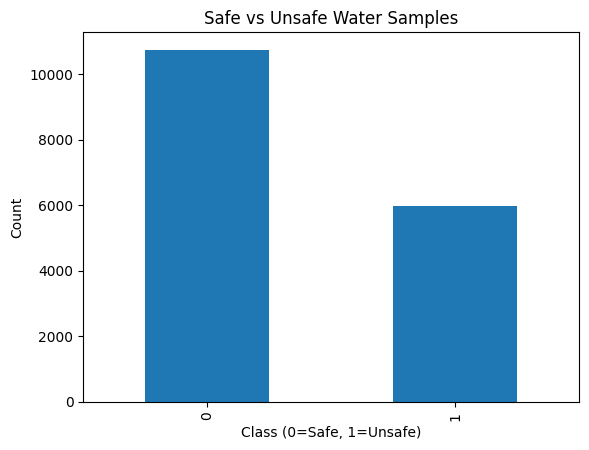

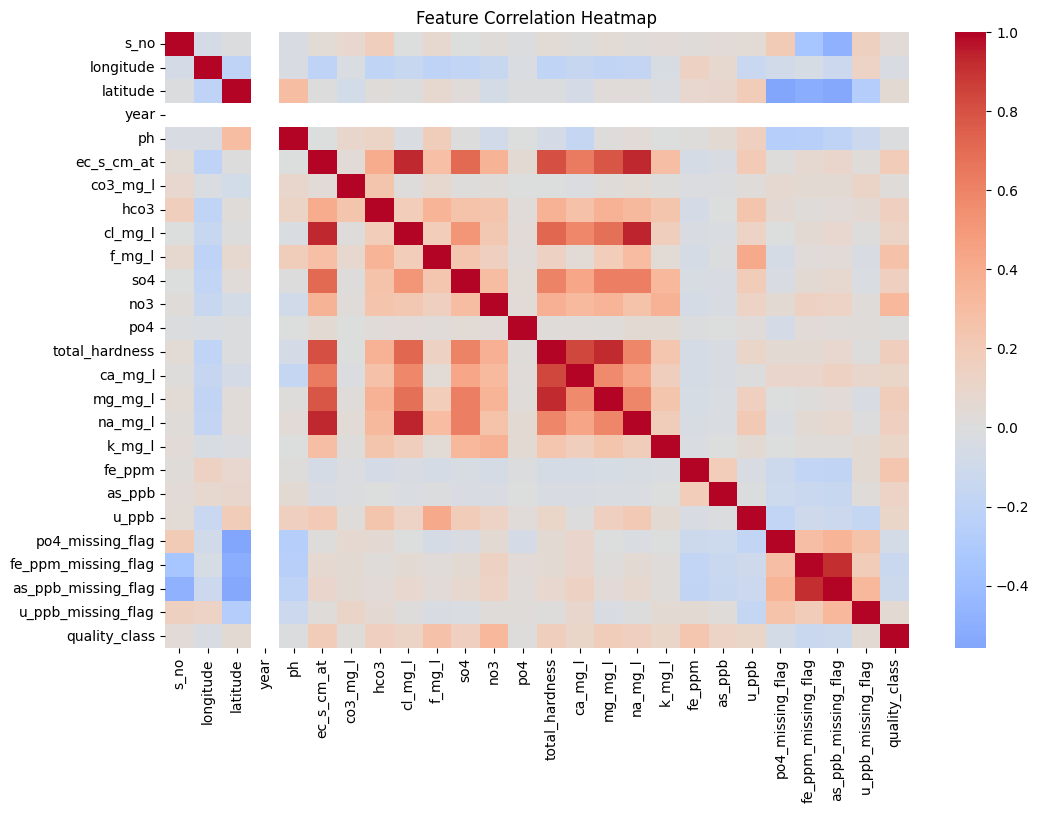

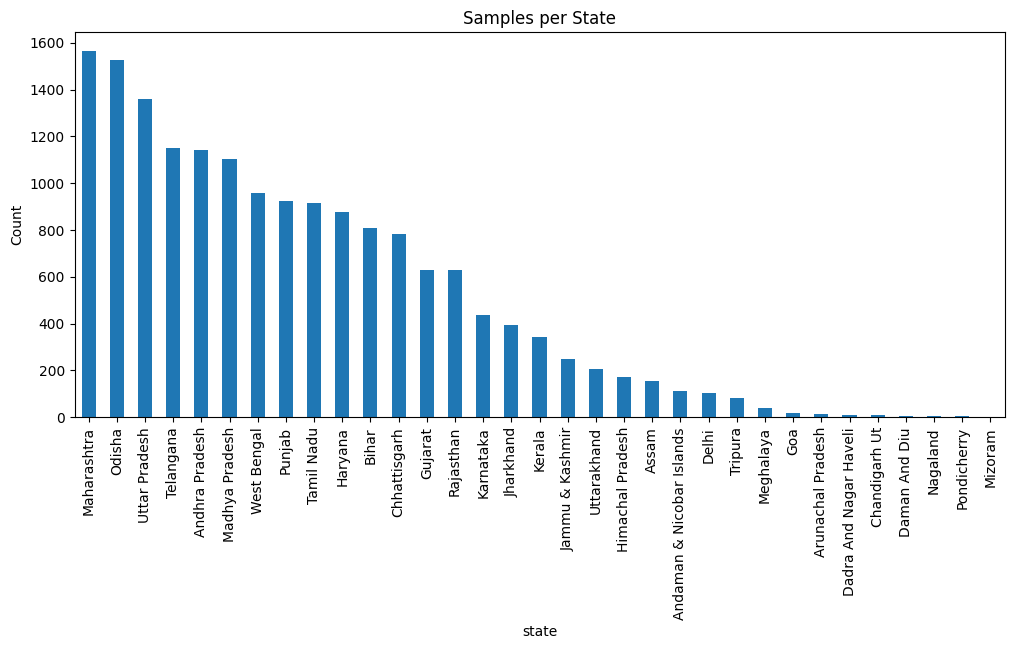

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =====================
# 0. LOAD DATA
# =====================
df = pd.read_csv("groundwater_cleaned_imputed.csv")  # <- load your file

# =====================
# 1. BASIC INFO
# =====================
print("\n🔹 Dataset shape:", df.shape)
print("\n🔹 Missing values (%):\n", df.isna().mean().round(3) * 100)

# =====================
# 2. VALUE RANGES CHECK
# =====================
ranges = {
    "ph": (0, 14),
    "ec_s_cm_at": (0, 5000),     
    "co3_mg_l_": (0, 1000),
    "hco3": (0, 1000),
    "cl_mg_l_": (0, 2000),
    "f_mg_l_": (0, 10),
    "so4": (0, 1500),
    "no3": (0, 300),
    "total_hardness": (0, 1500),
    "ca_mg_l_": (0, 500),
    "mg_mg_l_": (0, 500),
    "na_mg_l_": (0, 1000),
    "k_mg_l_": (0, 100),
    "fe_ppm_": (0, 10),
    "as_ppb_": (0, 1000),
    "u_ppb_": (0, 1000),
    "po4": (0, 50)
}

print("\n🔹 Out-of-range values:")
for col, (low, high) in ranges.items():
    if col in df.columns:
        invalid = df[(df[col] < low) | (df[col] > high)]
        print(f"{col}: {len(invalid)} out-of-range")

# =====================
# 3. TARGET BALANCE
# =====================
if "quality_class" in df.columns:
    print("\n🔹 Target distribution:")
    print(df["quality_class"].value_counts(normalize=True))

    df["quality_class"].value_counts().plot(kind="bar")
    plt.title("Safe vs Unsafe Water Samples")
    plt.xlabel("Class (0=Safe, 1=Unsafe)")
    plt.ylabel("Count")
    plt.show()

# =====================
# 4. CORRELATION HEATMAP
# =====================
num_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# =====================
# 5. GEOGRAPHIC COVERAGE
# =====================
if "state" in df.columns:
    plt.figure(figsize=(12,5))
    df["state"].value_counts().plot(kind="bar")
    plt.title("Samples per State")
    plt.ylabel("Count")
    plt.show()



🔹 Dataset shape: (16737, 29)

🔹 Missing values (%):
 s_no                   0.0
state                  0.0
district               0.0
location               0.0
longitude              0.0
latitude               0.0
year                   0.0
ph                     0.0
ec_s_cm_at             0.0
co3_mg_l               0.0
hco3                   0.0
cl_mg_l                0.0
f_mg_l                 0.0
so4                    0.0
no3                    0.0
po4                    0.0
total_hardness         0.0
ca_mg_l                0.0
mg_mg_l                0.0
na_mg_l                0.0
k_mg_l                 0.0
fe_ppm                 0.0
as_ppb                 0.0
u_ppb                  0.0
po4_missing_flag       0.0
fe_ppm_missing_flag    0.0
as_ppb_missing_flag    0.0
u_ppb_missing_flag     0.0
quality_class          0.0
dtype: float64

🔹 Statistical Summary:
                       count         mean          std        min        25%  \
s_no                 16737.0  8386.306686  4

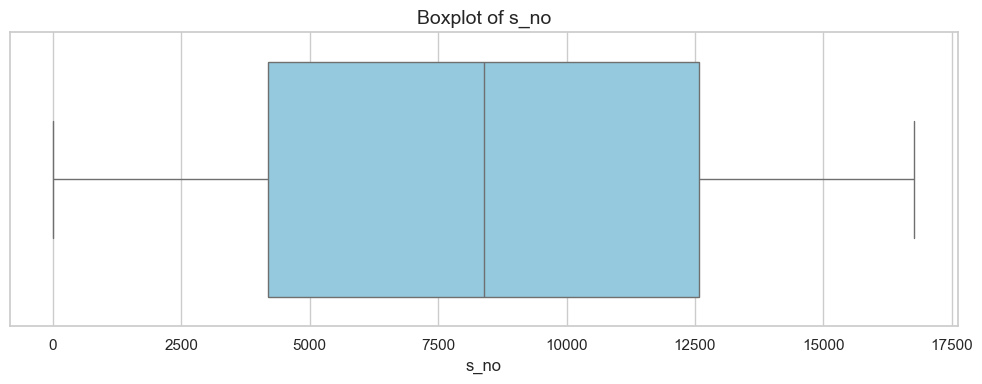

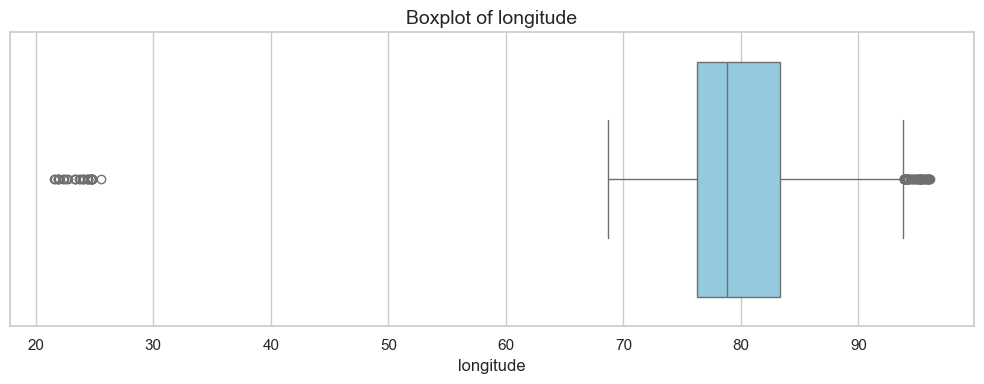

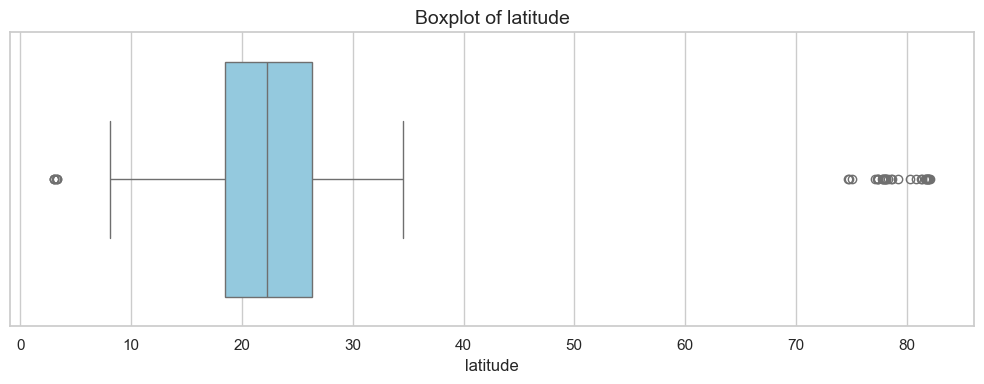

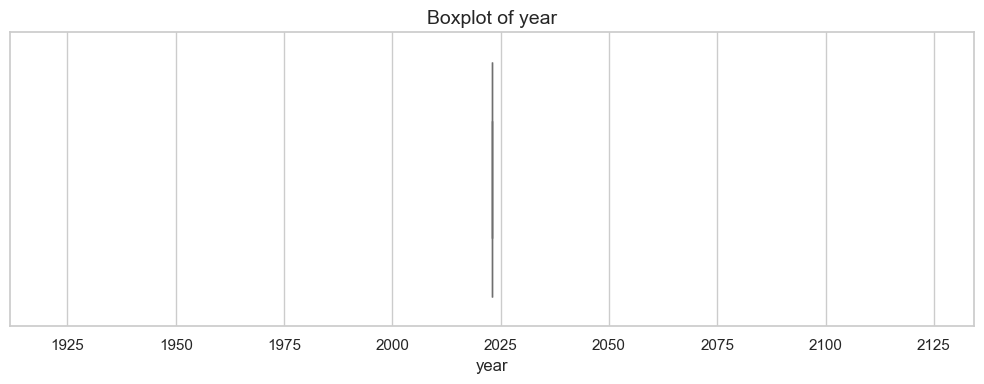

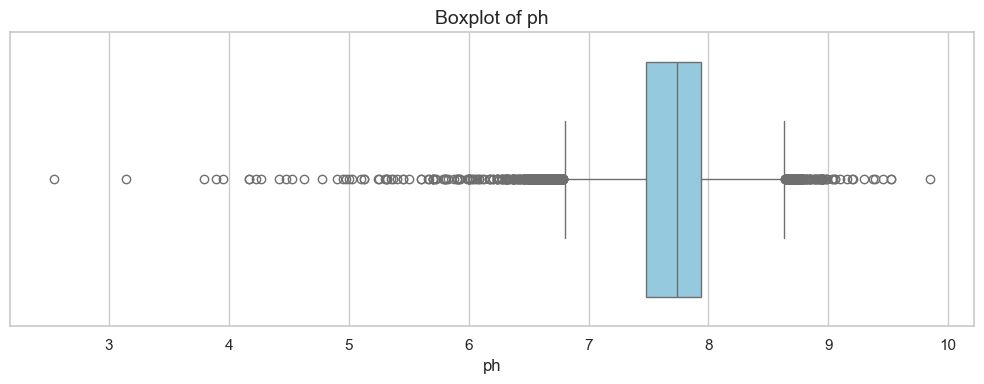

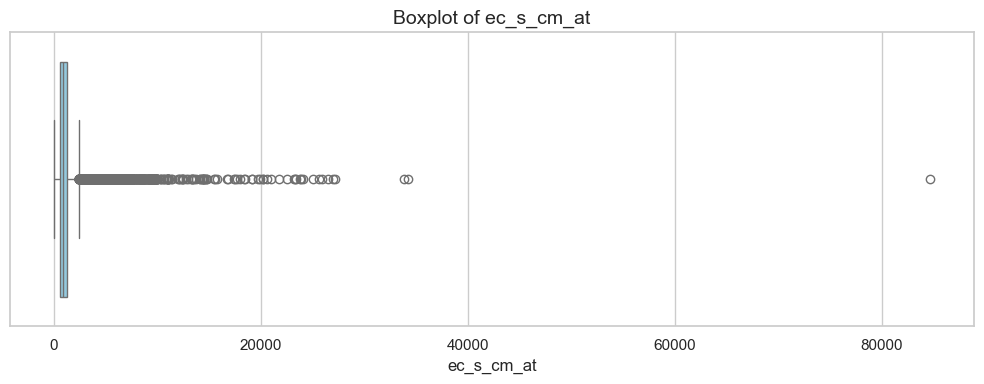

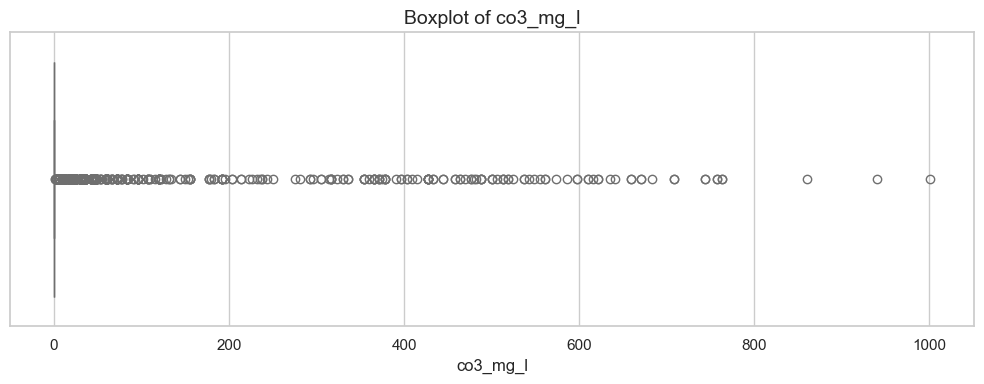

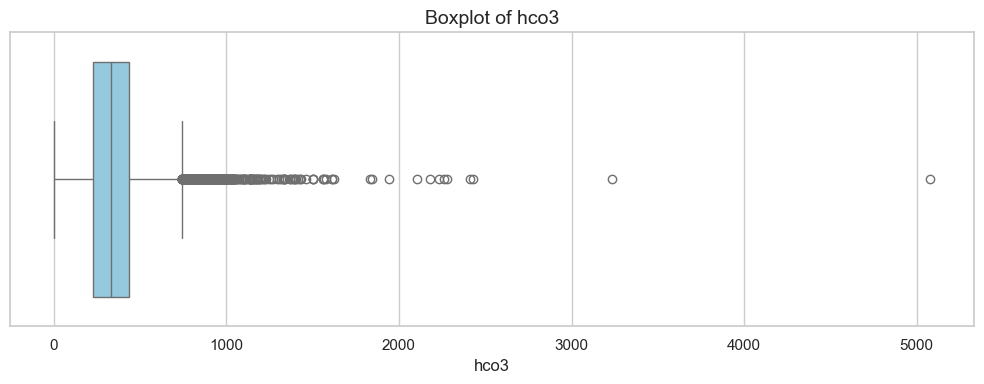

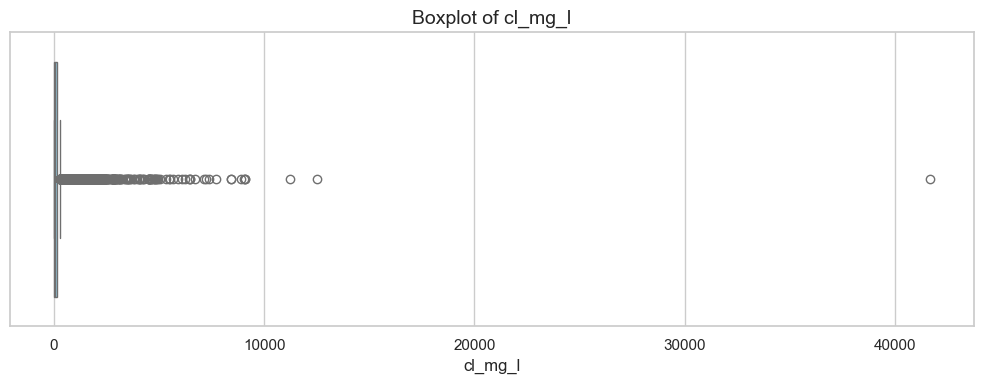

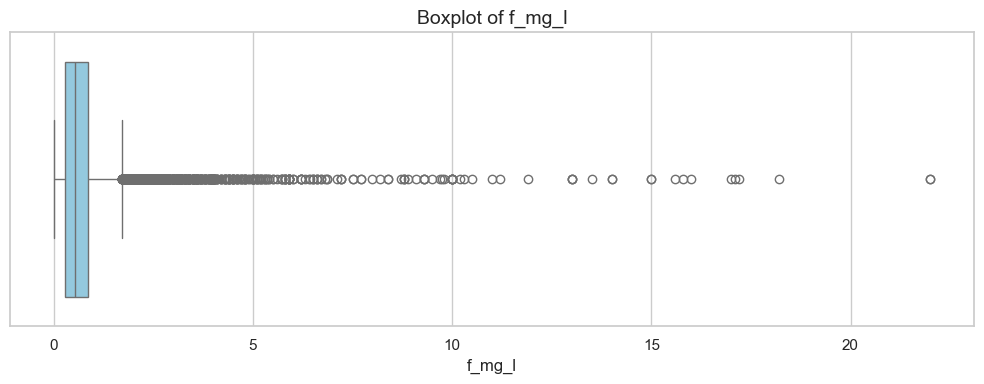

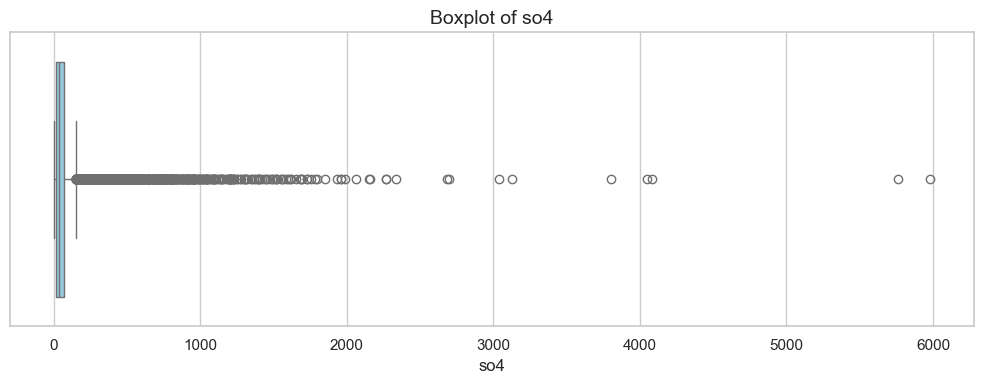

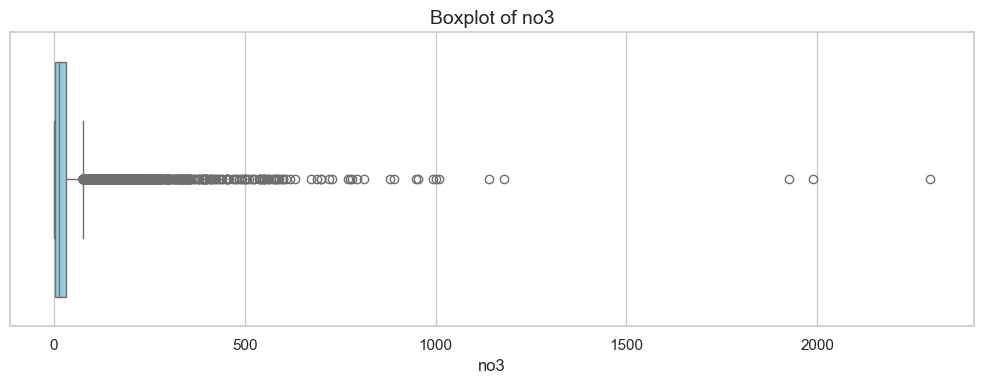

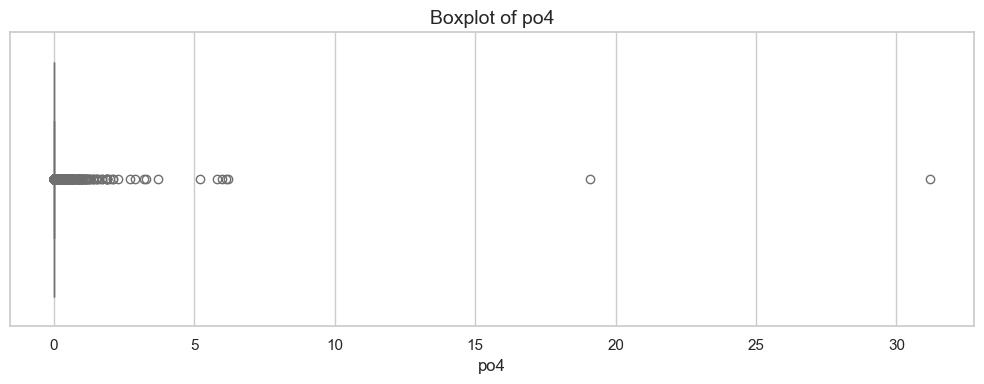

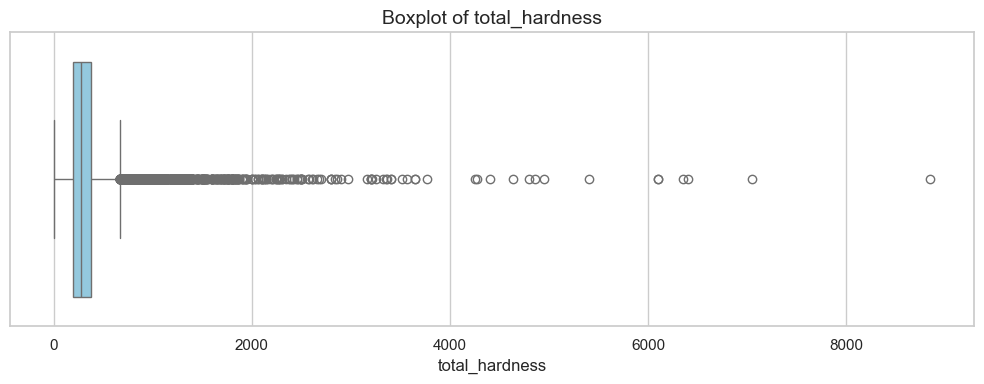

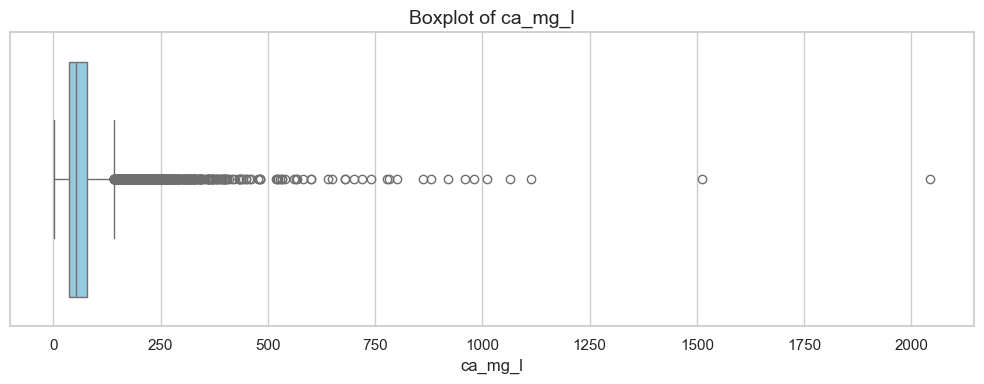

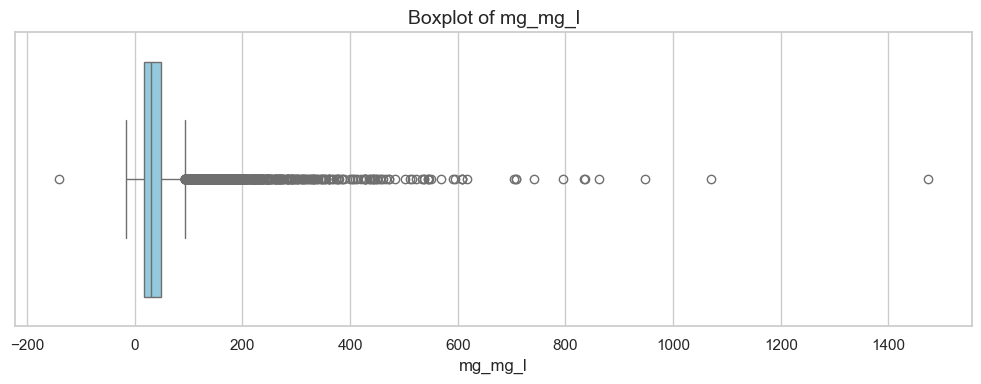

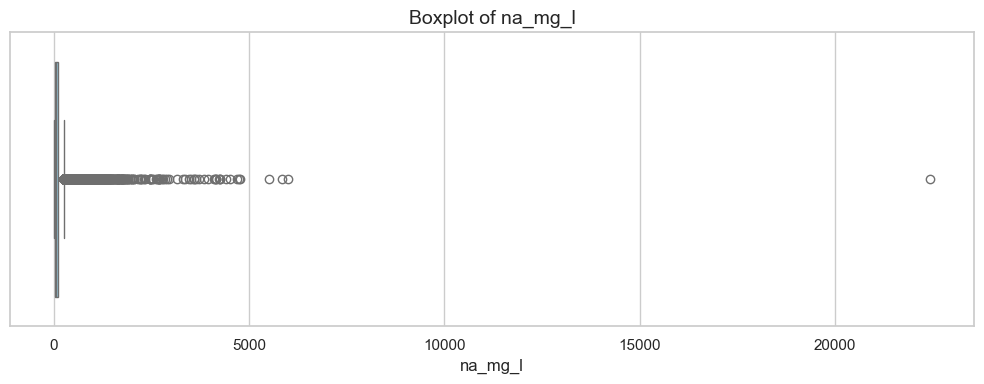

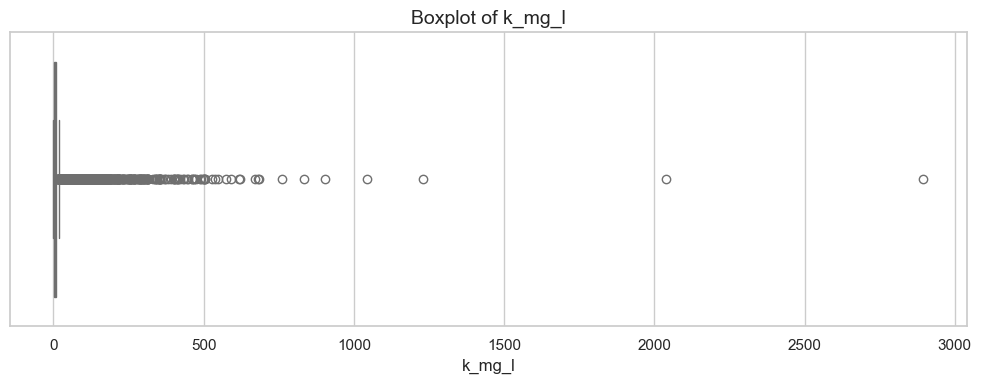

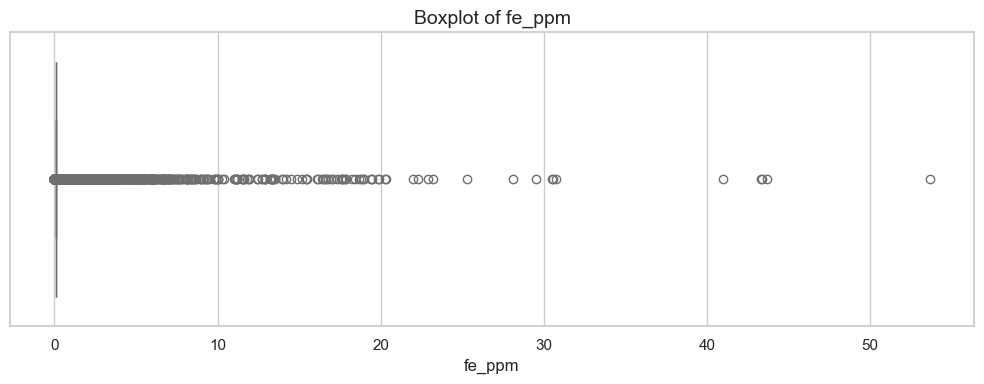

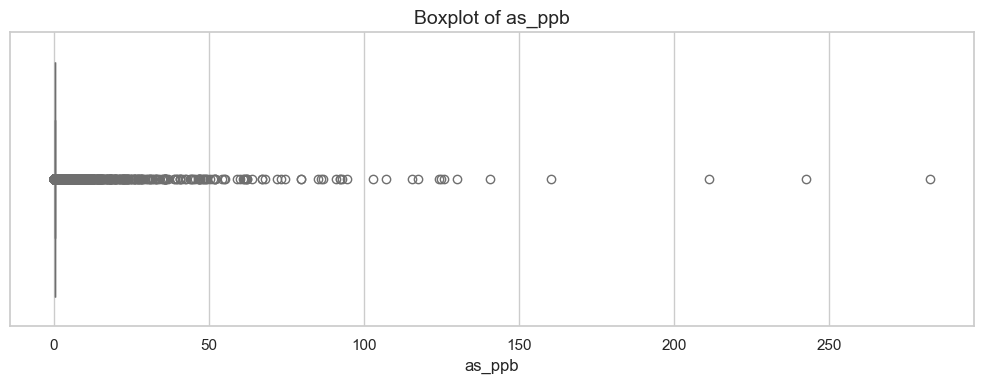

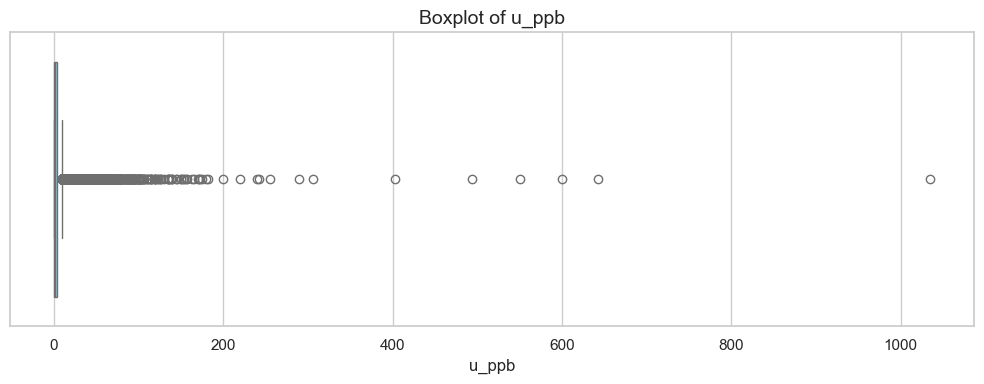

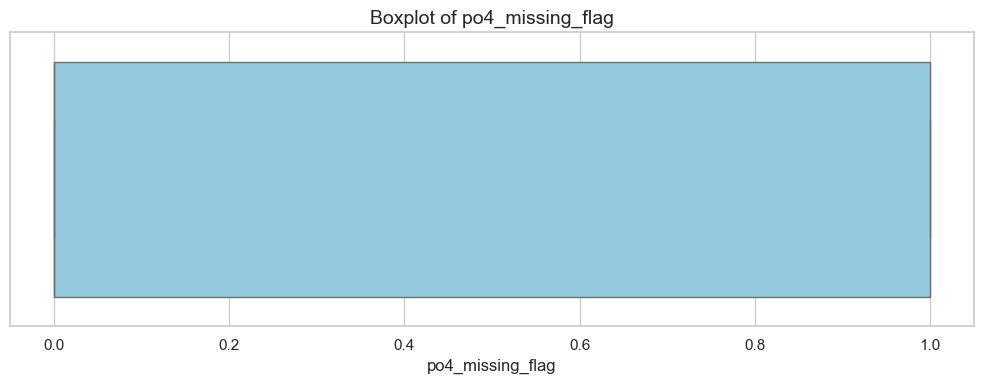

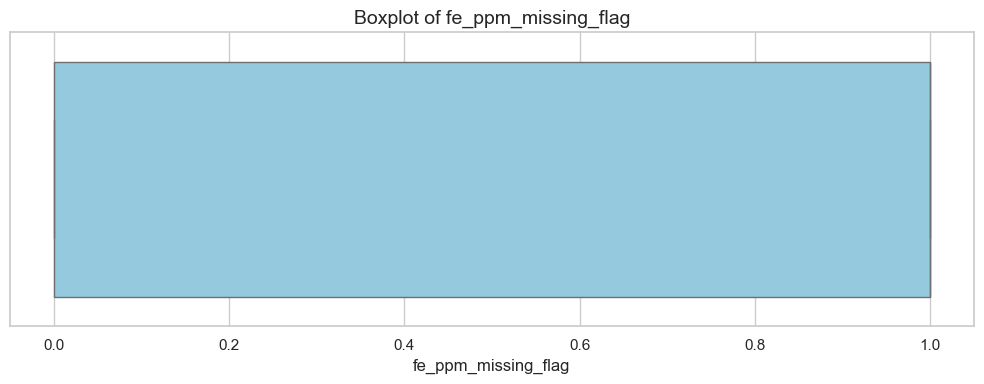

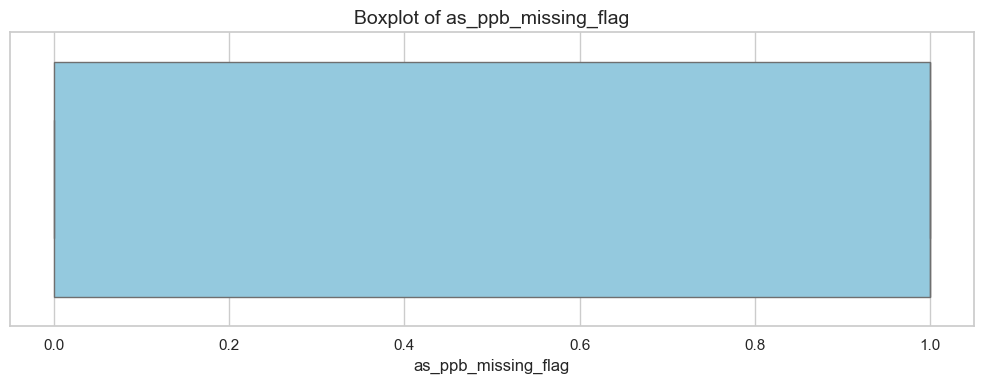

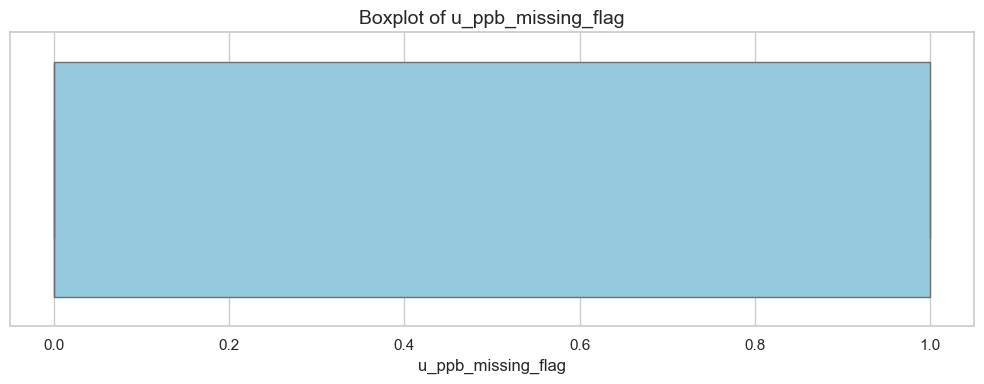

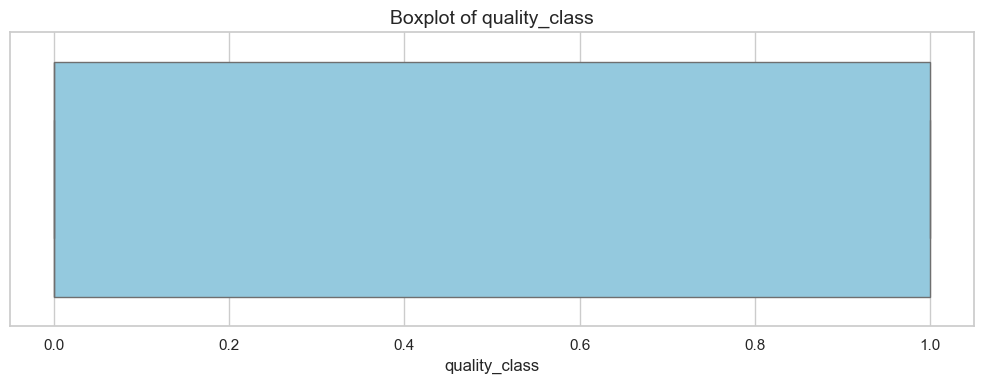

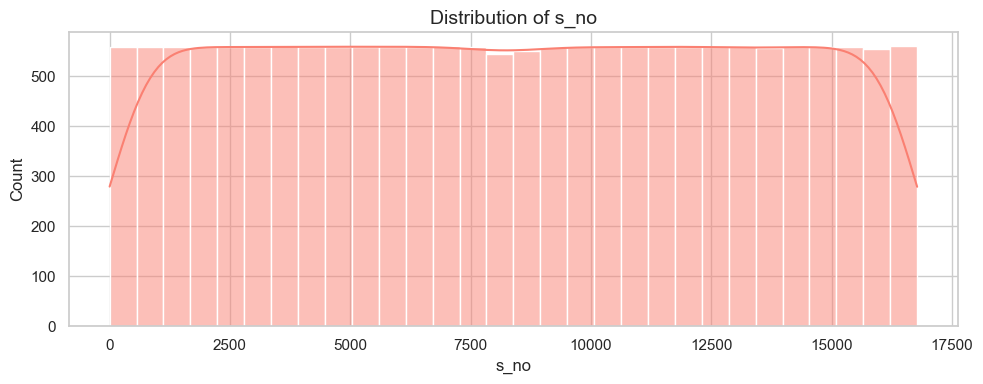

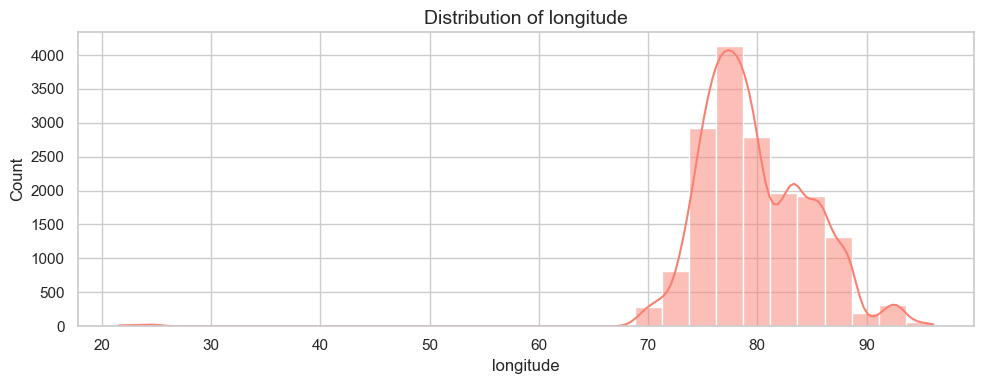

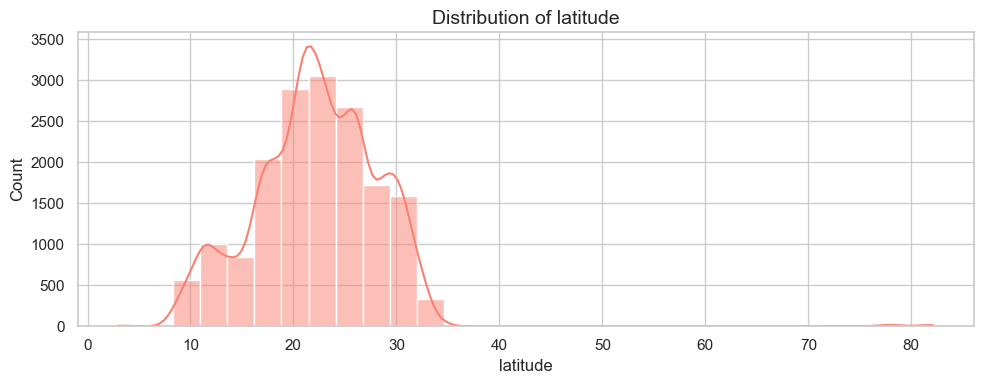

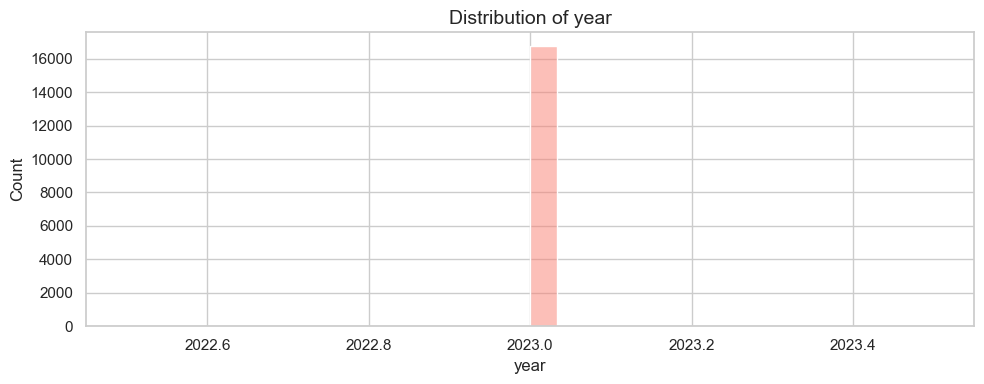

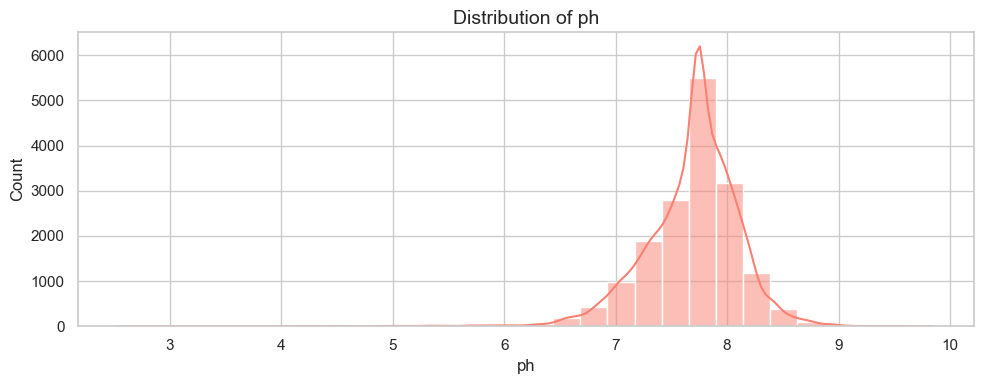

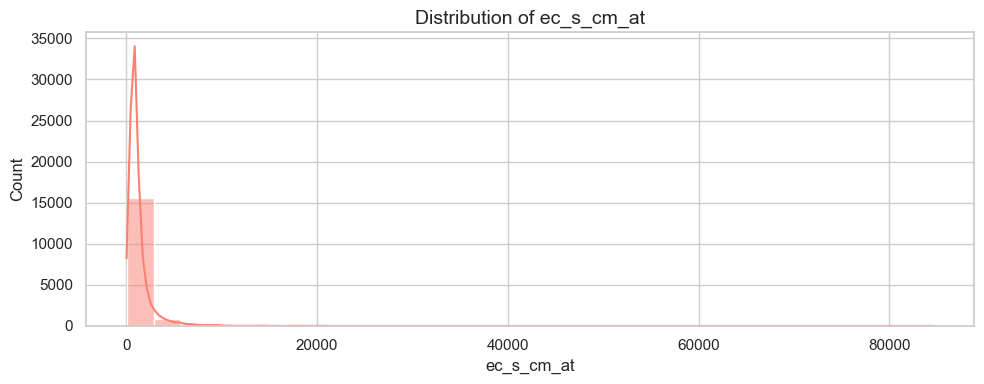

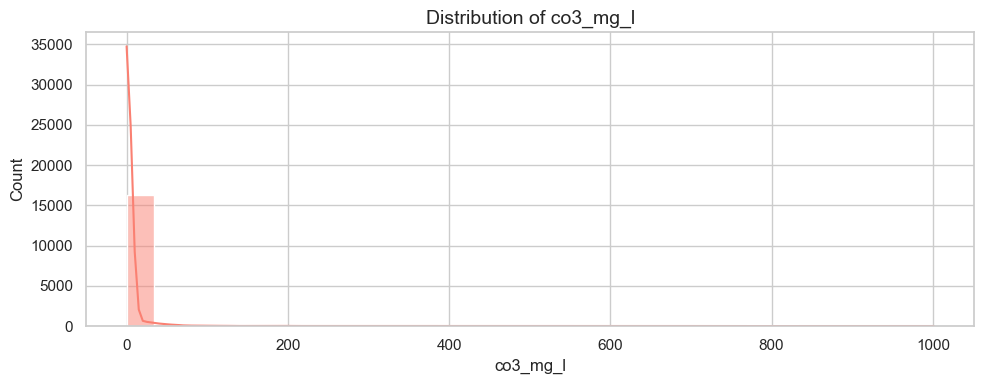

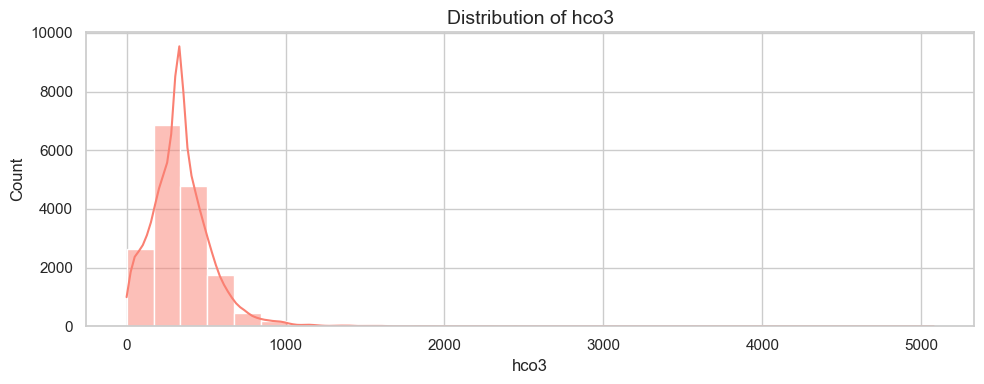

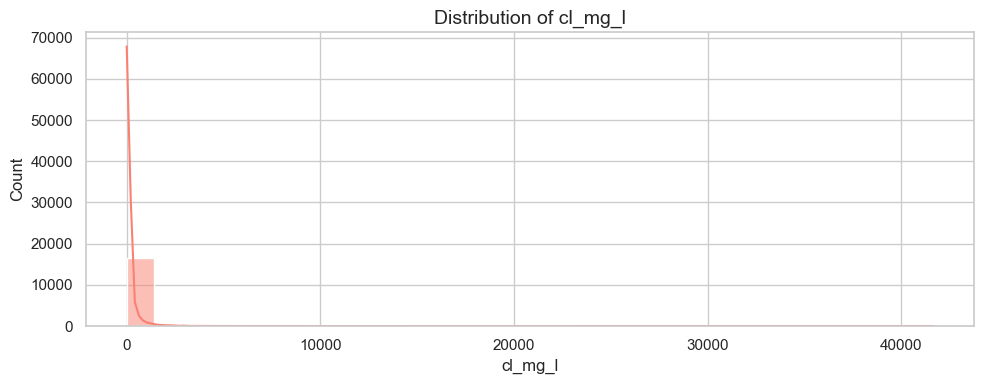

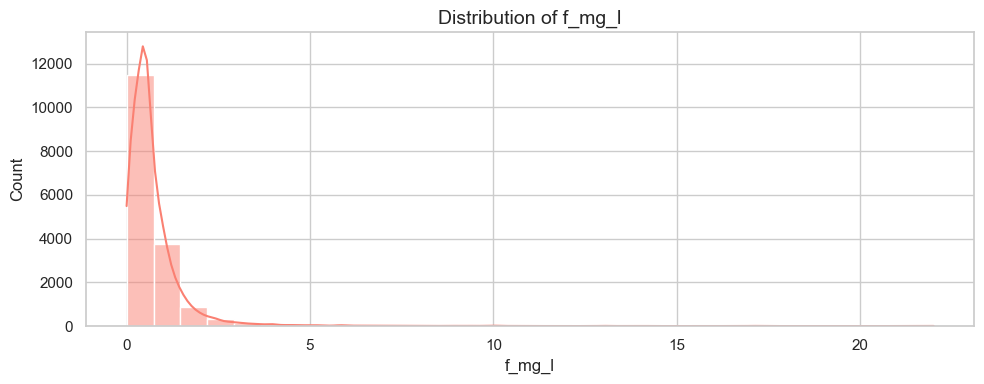

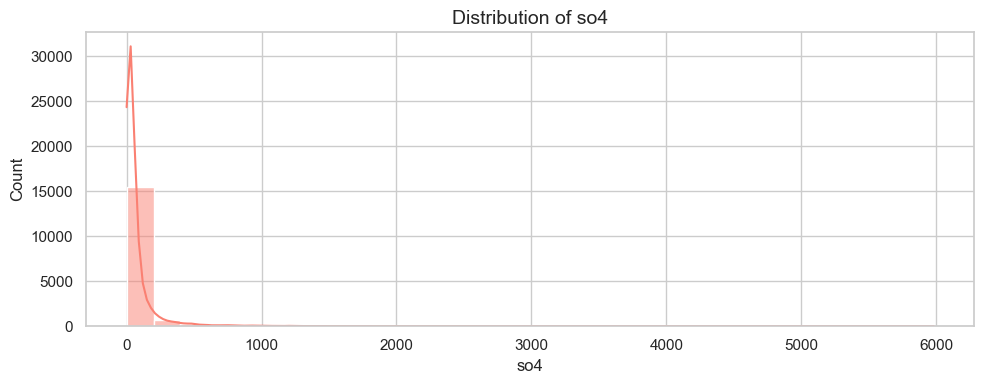

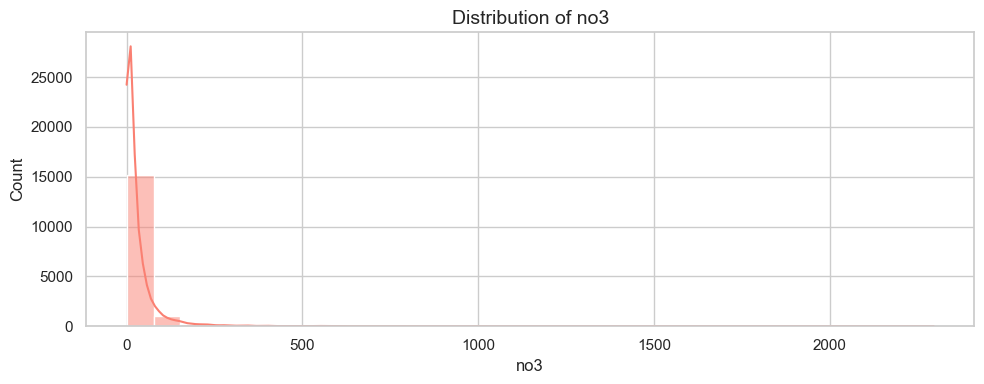

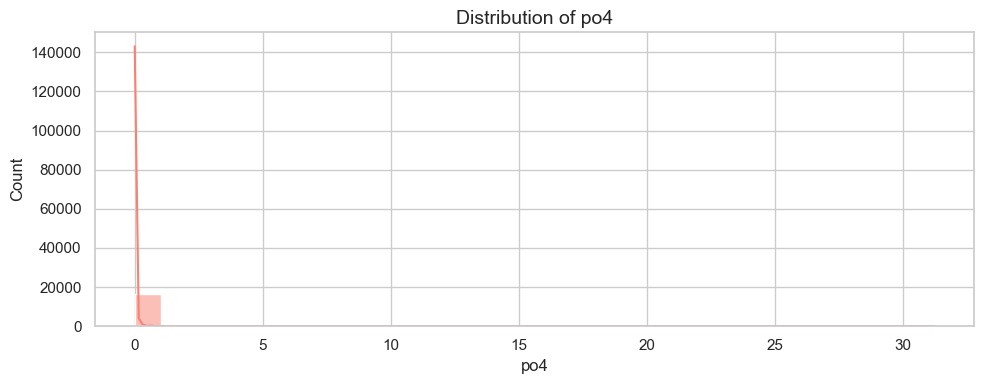

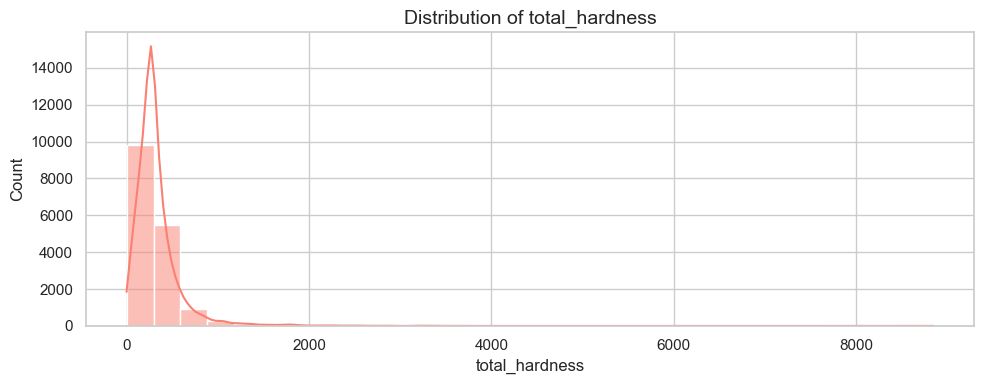

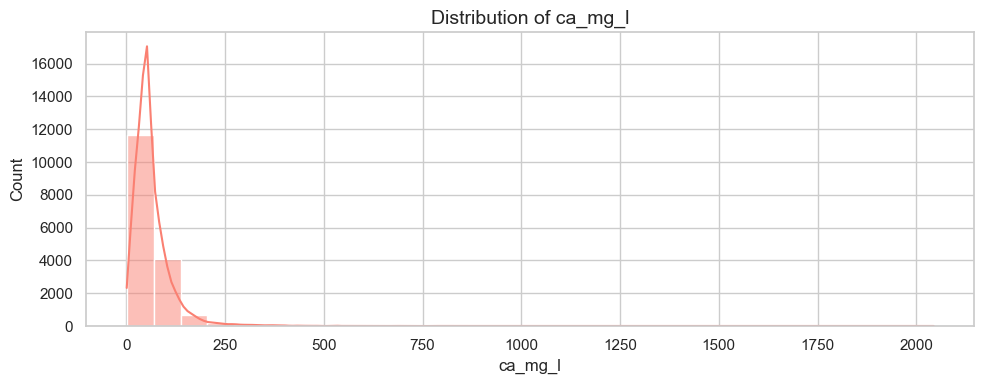

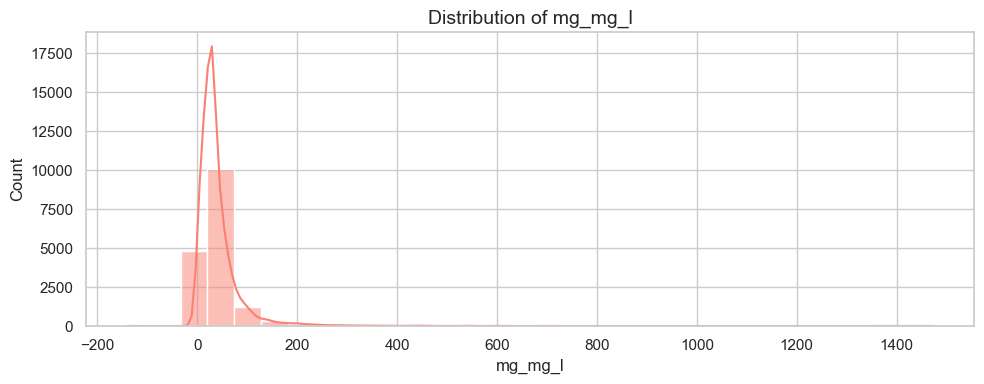

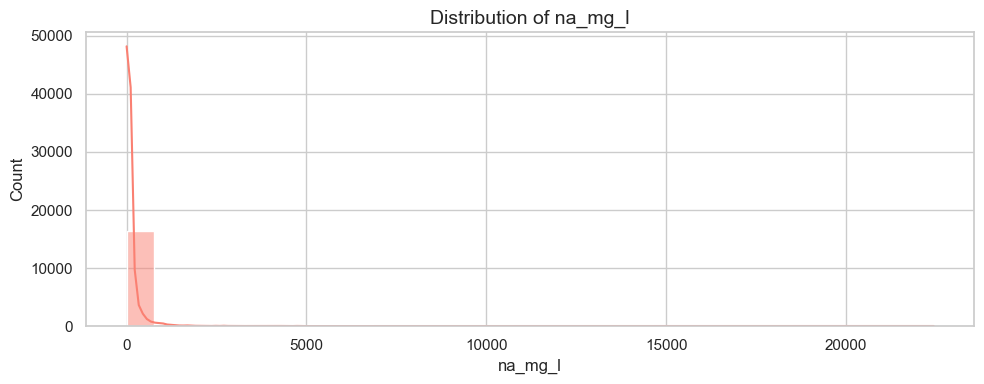

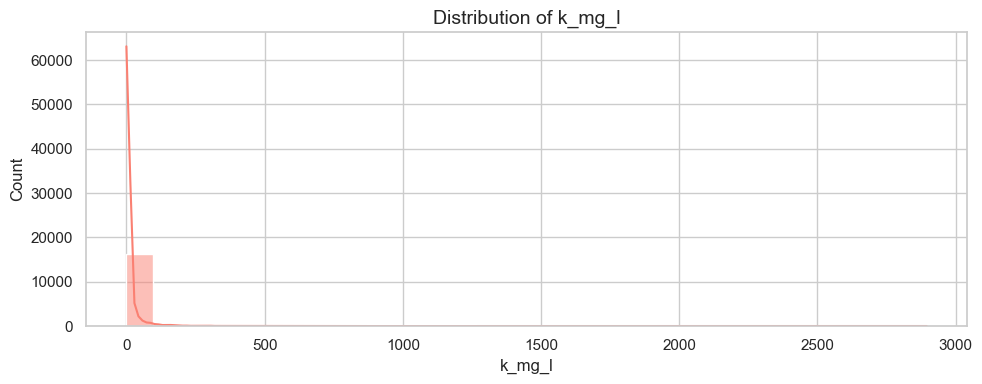

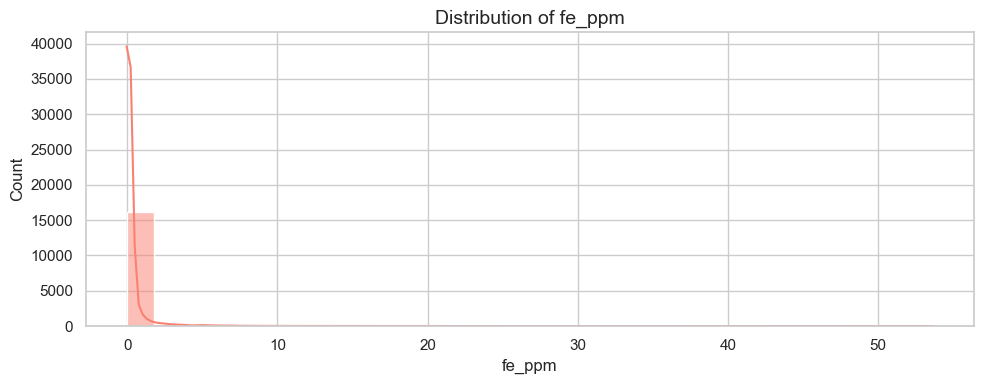

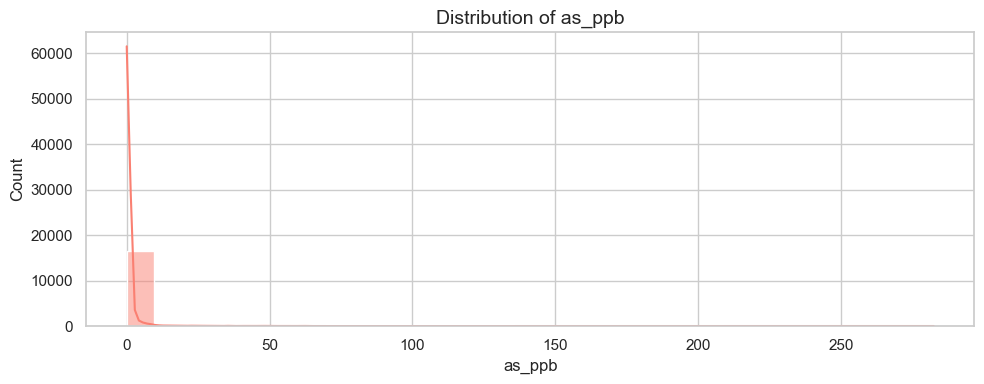

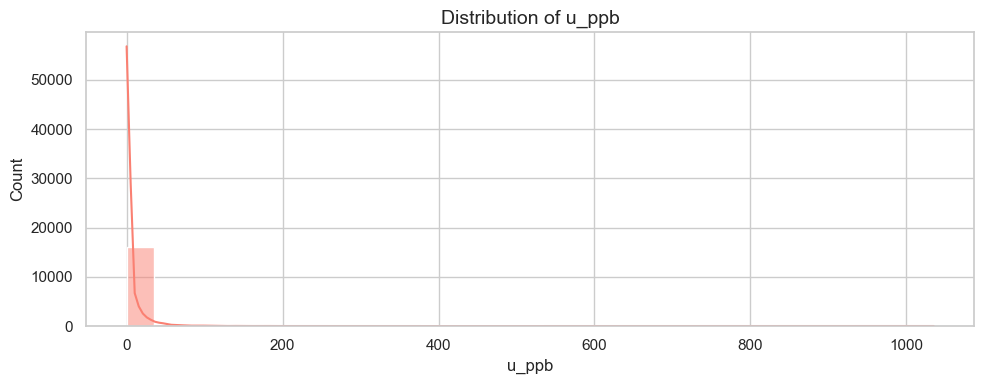

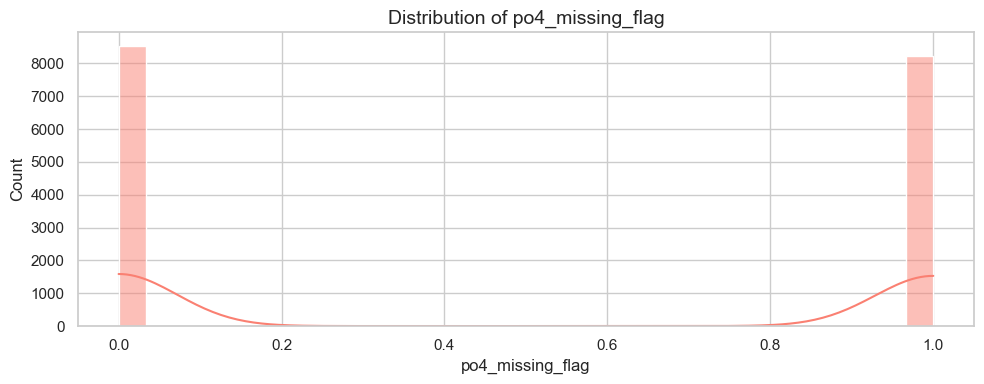

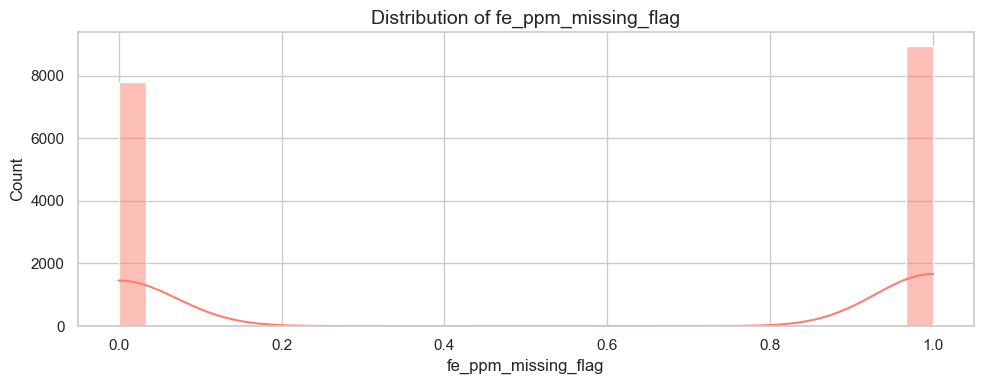

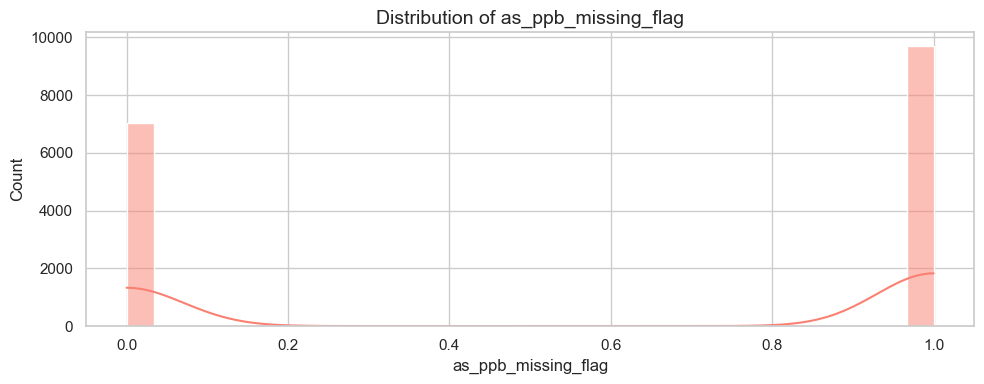

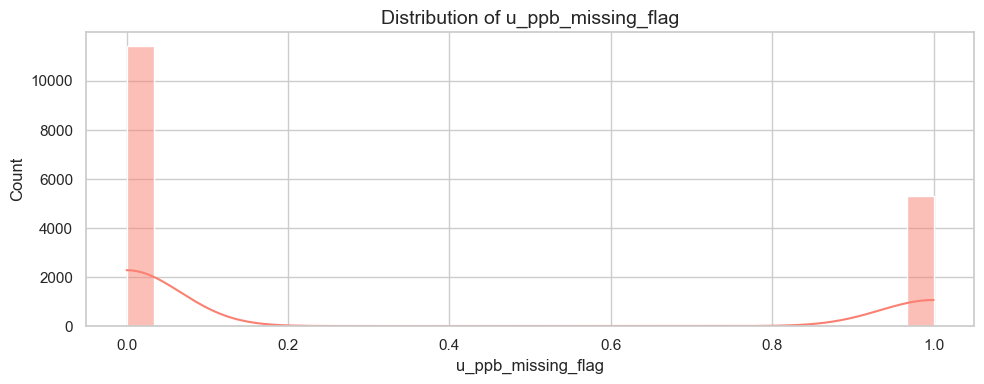

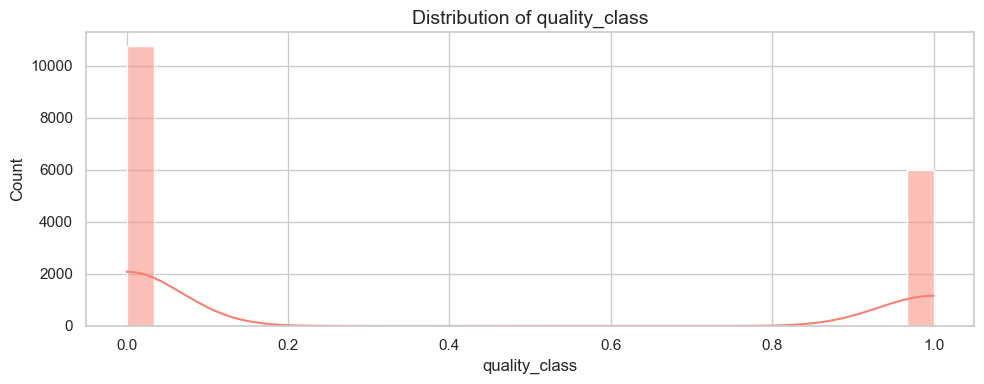

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


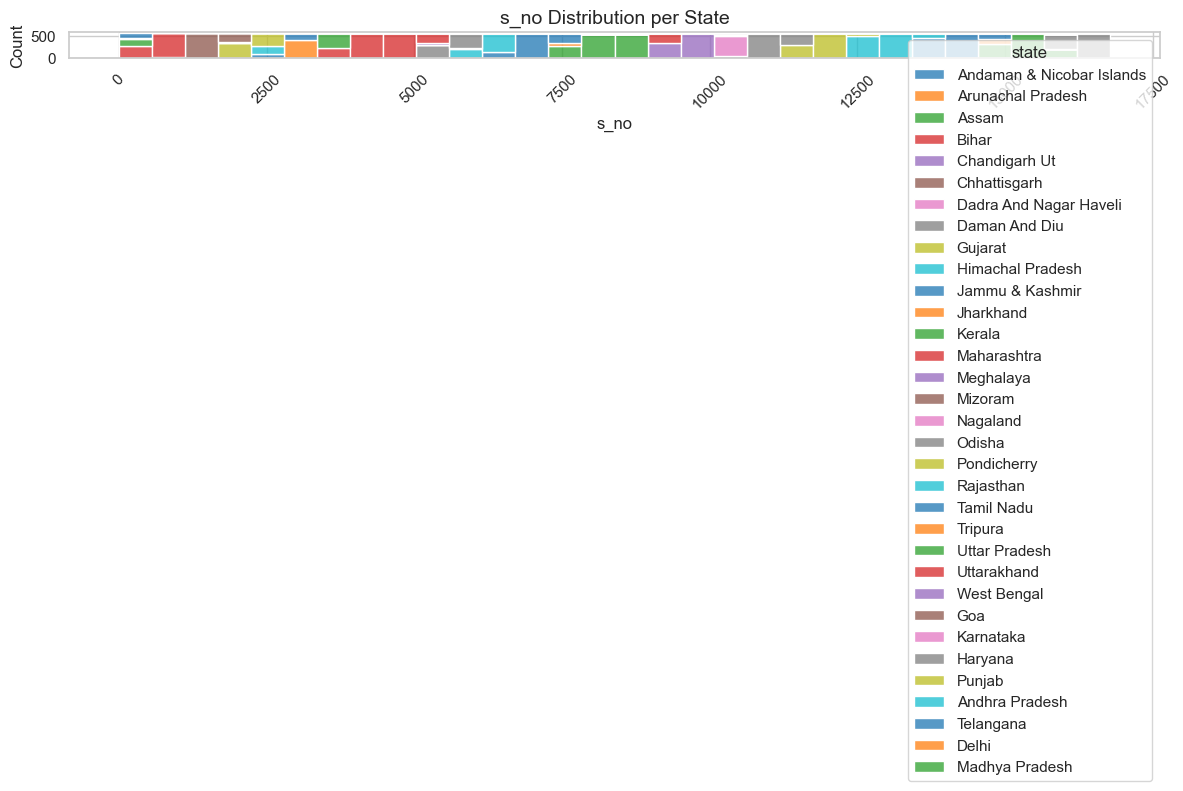

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


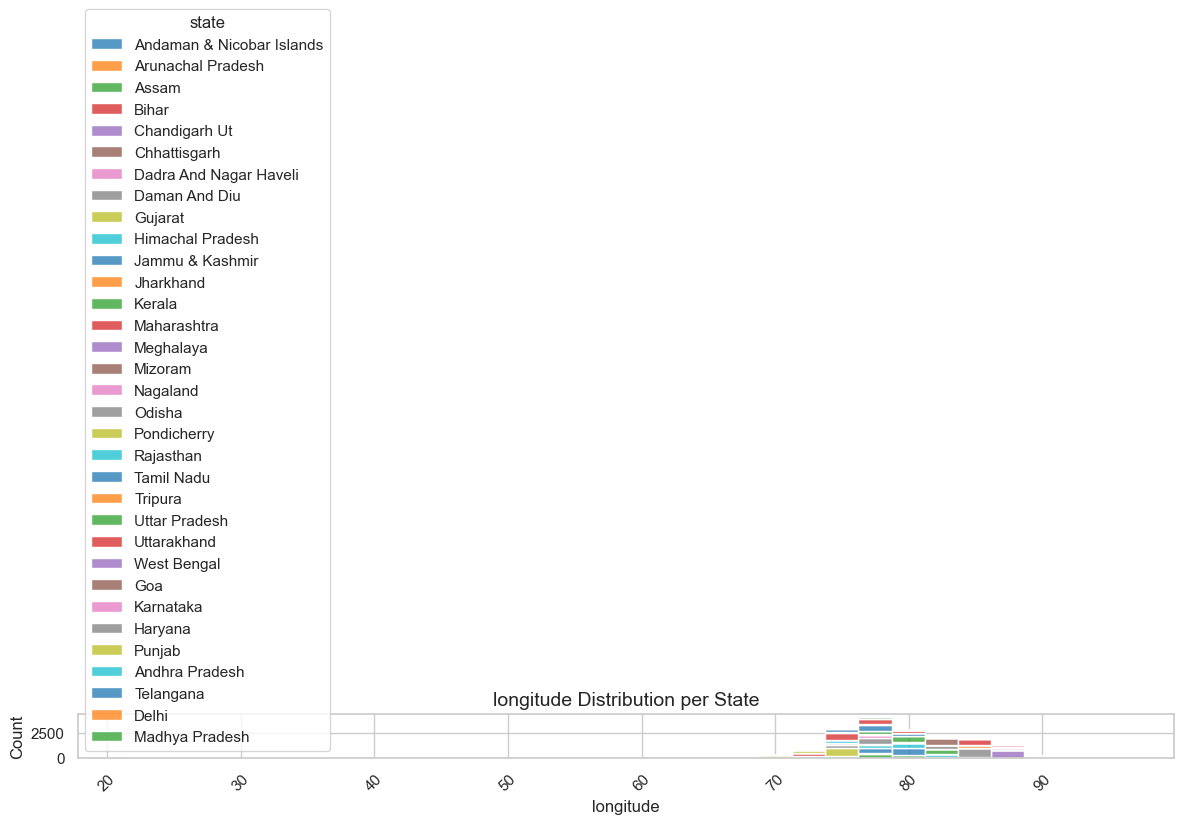

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


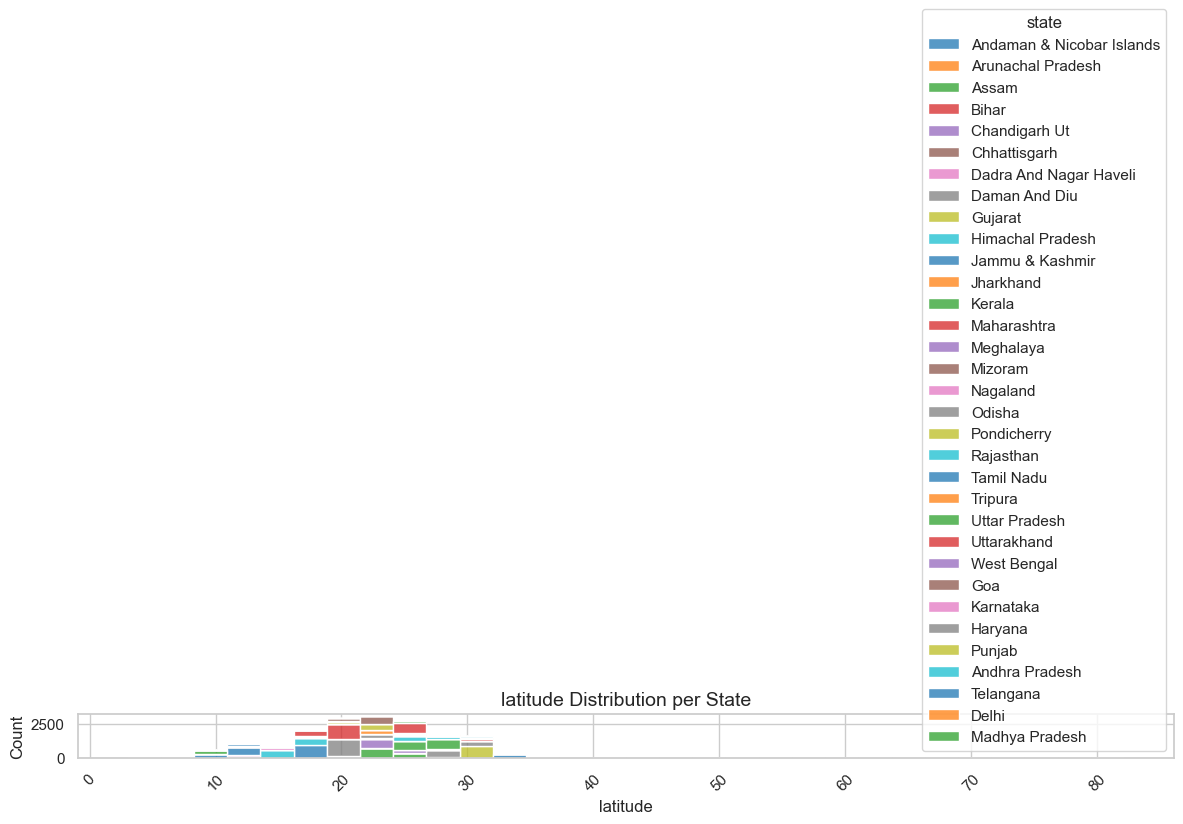

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


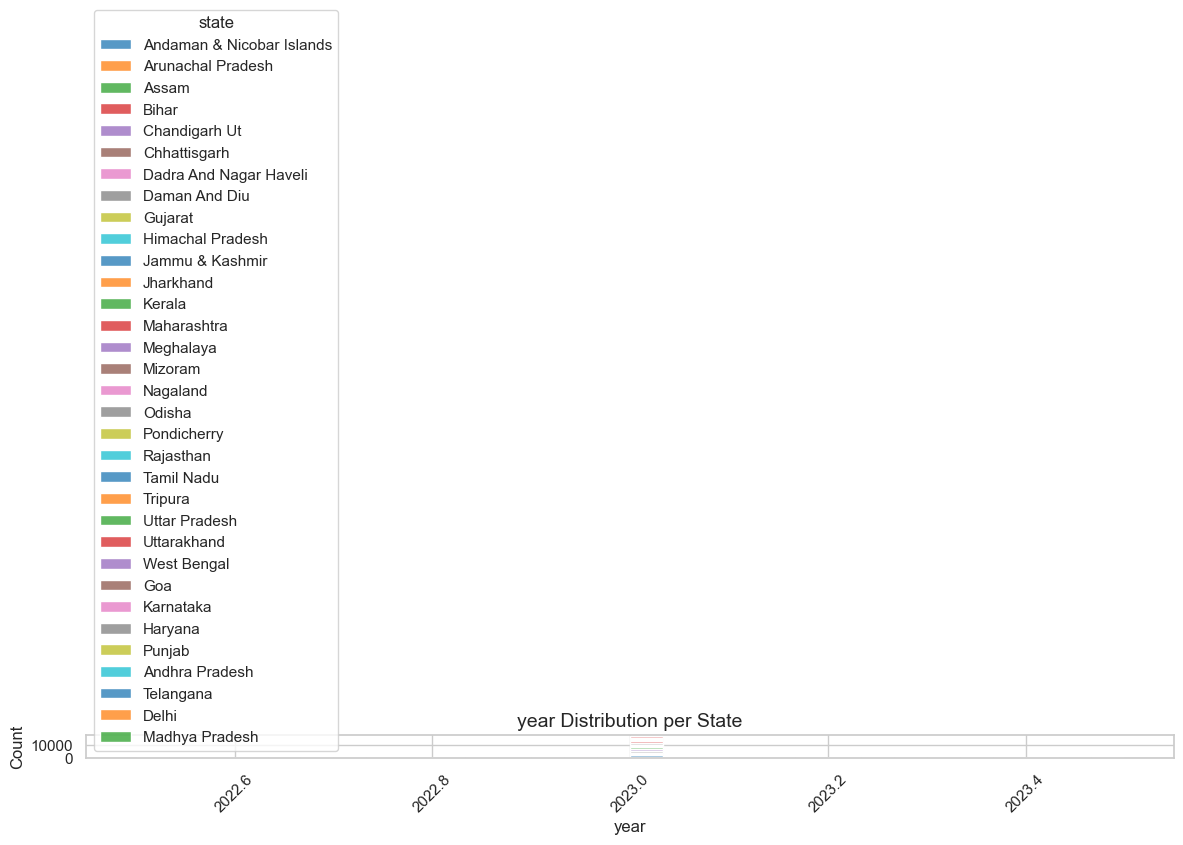

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


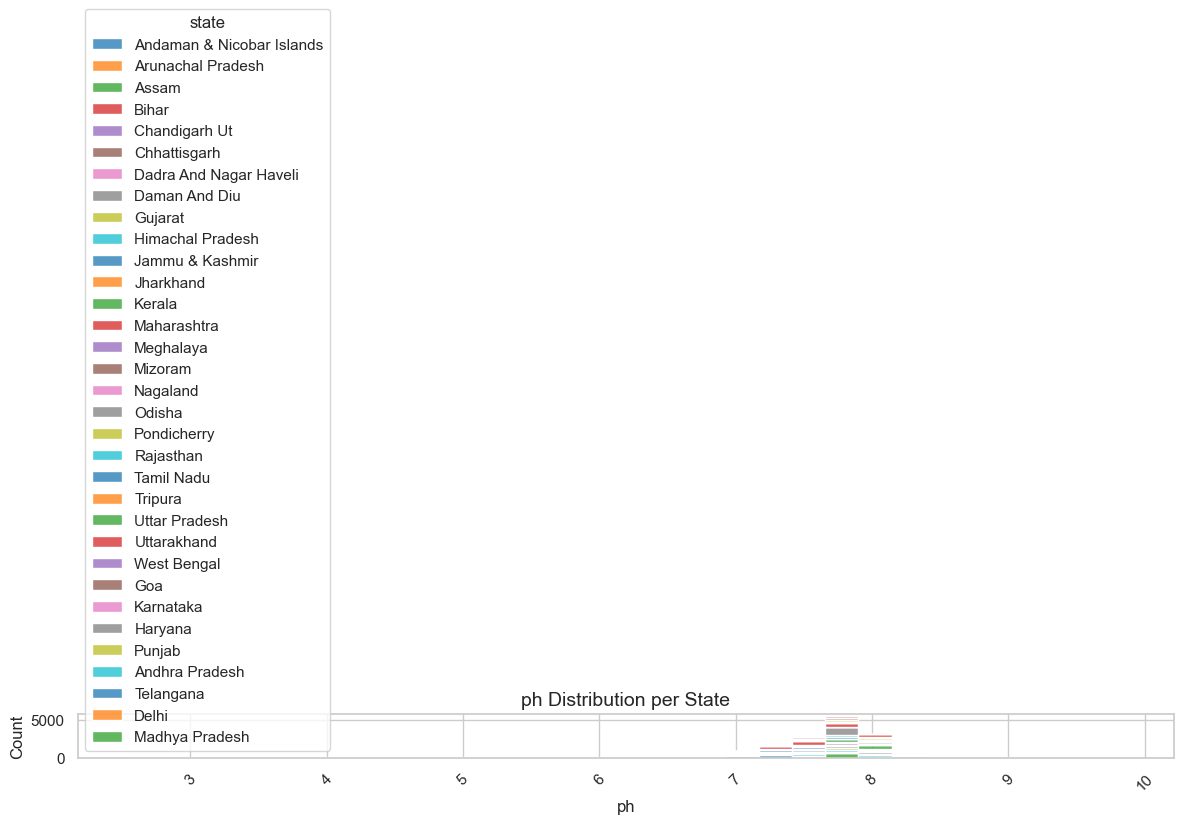

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


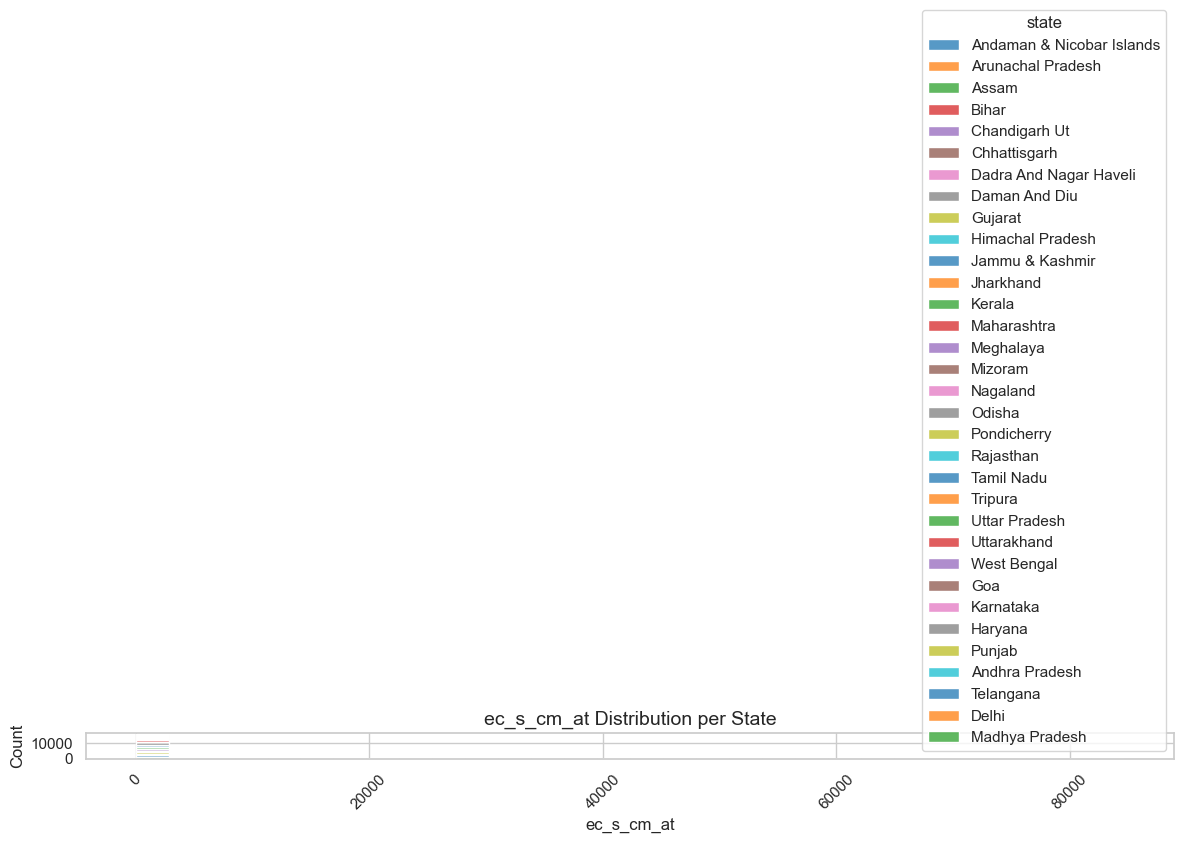

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


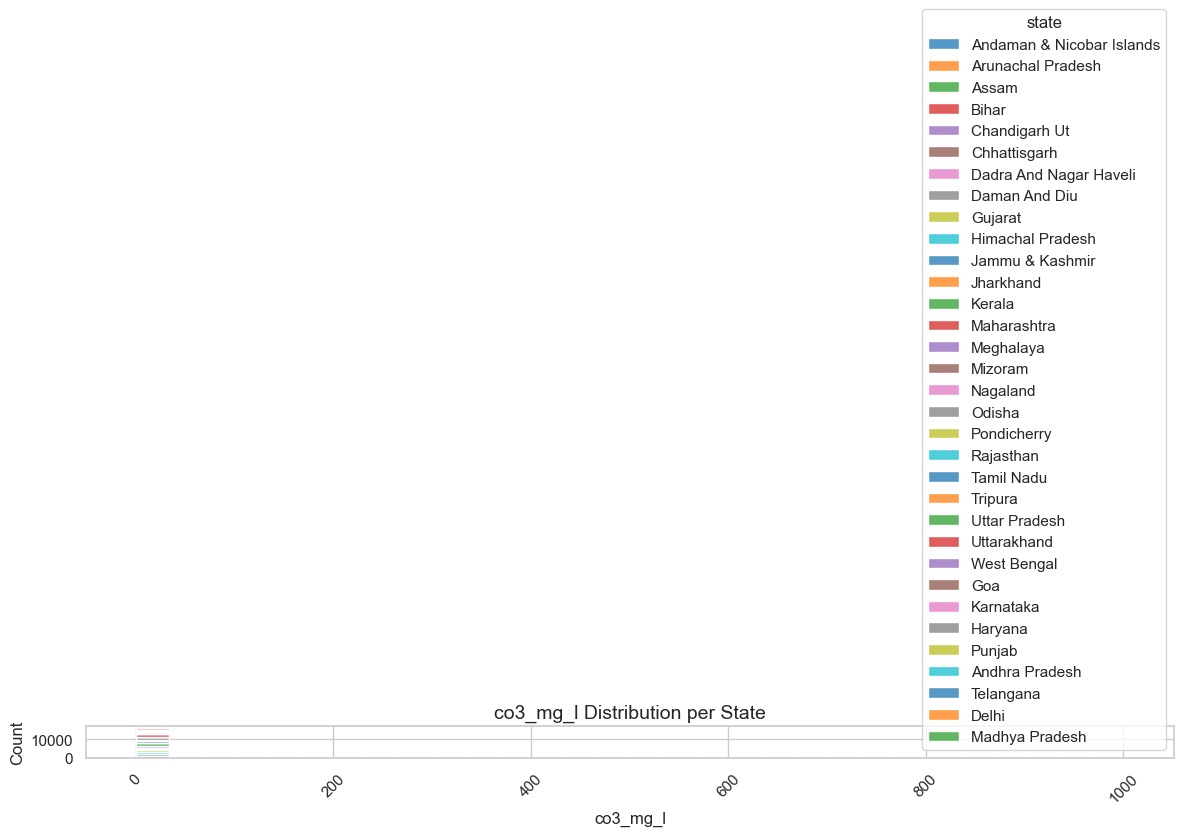

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


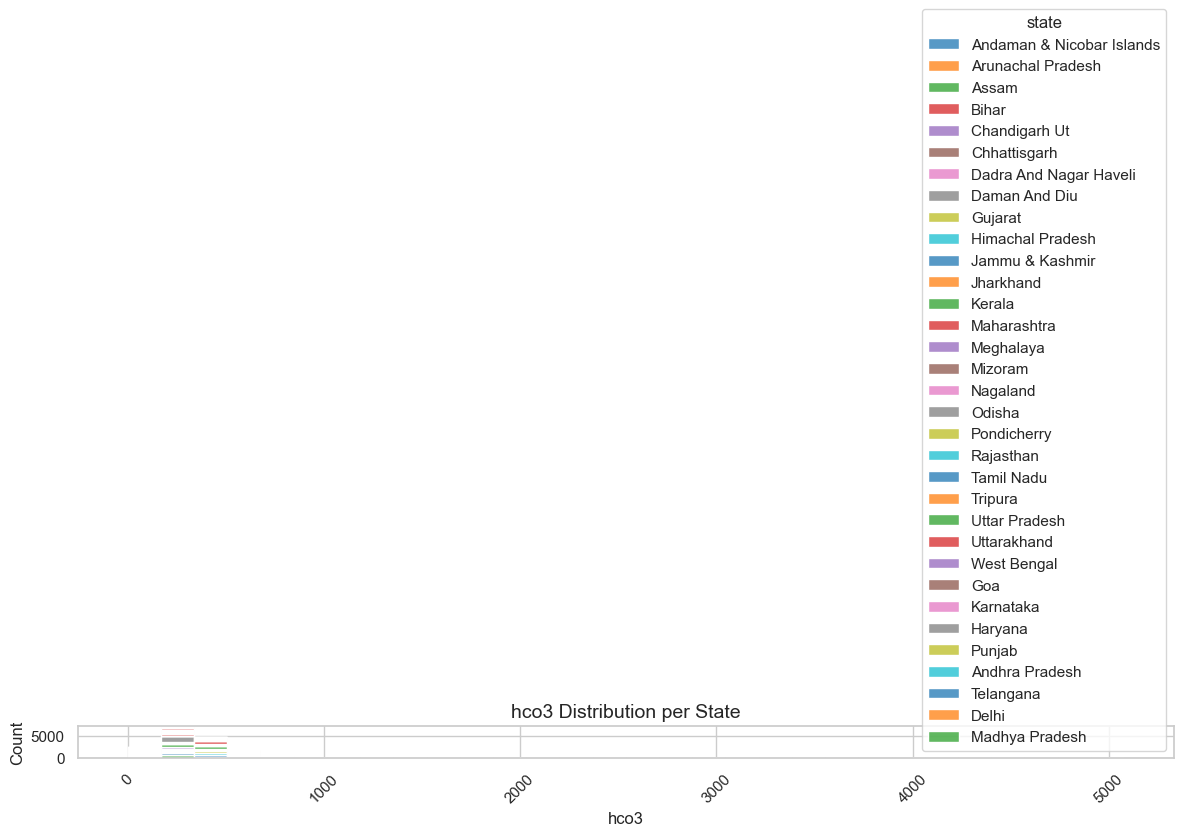

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


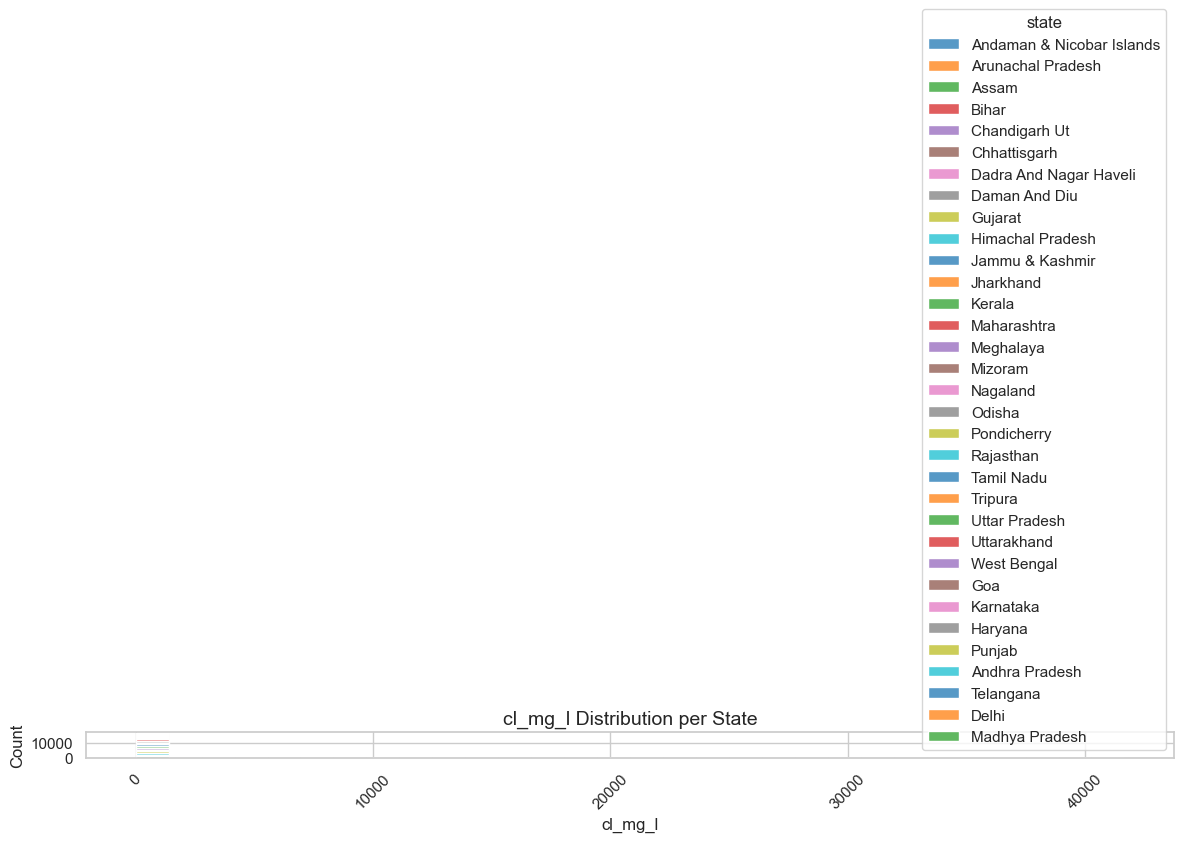

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


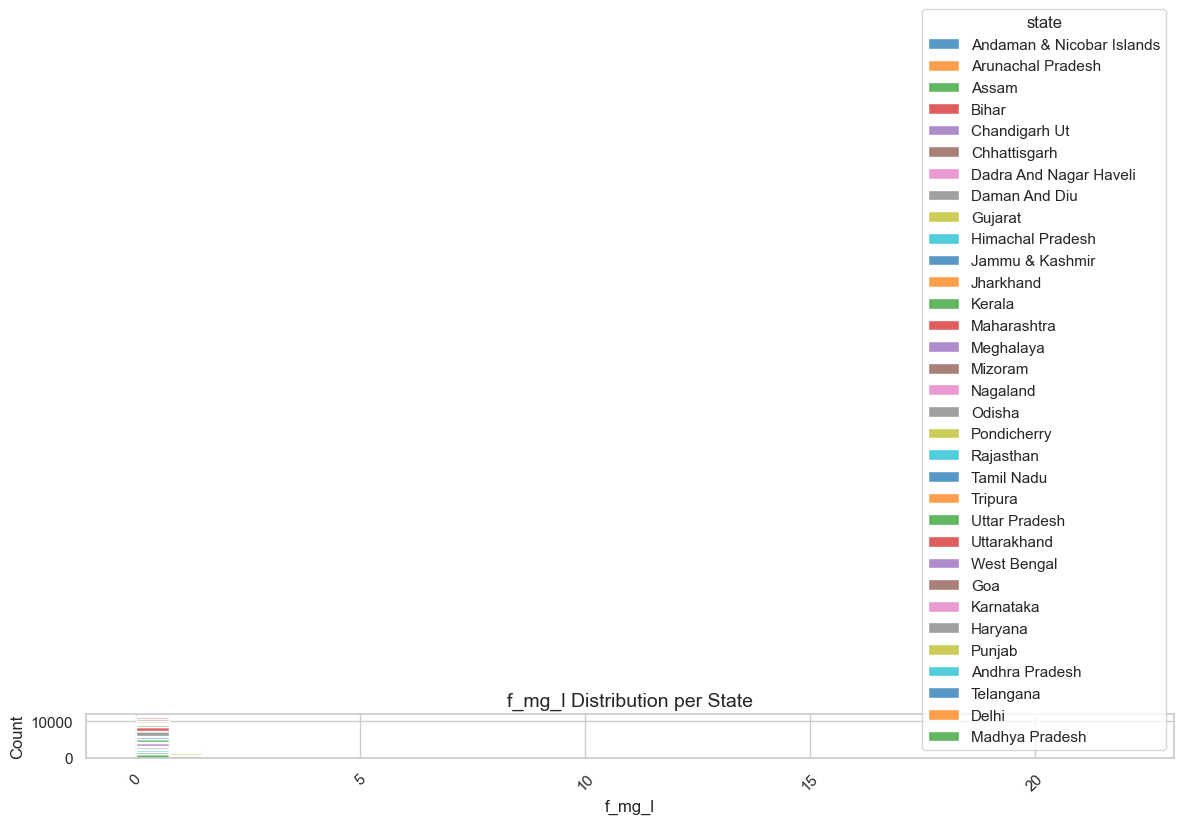

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


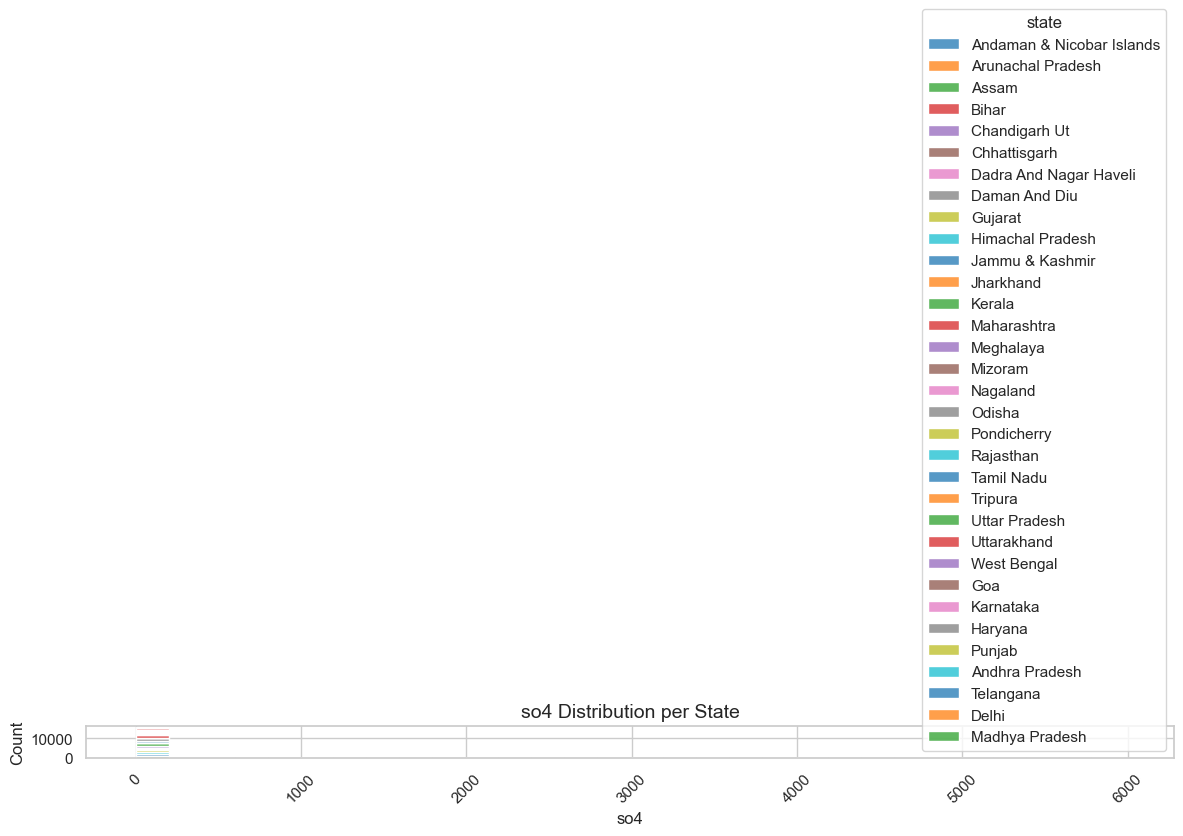

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


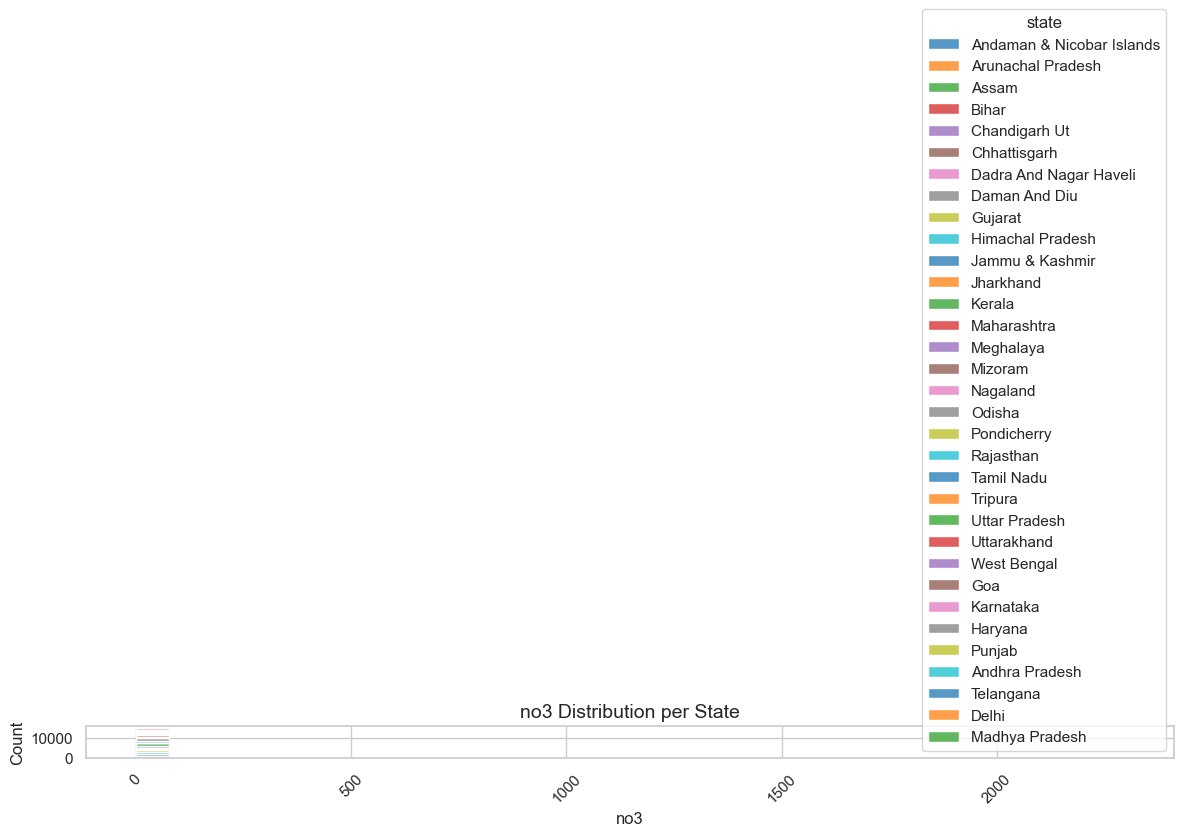

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


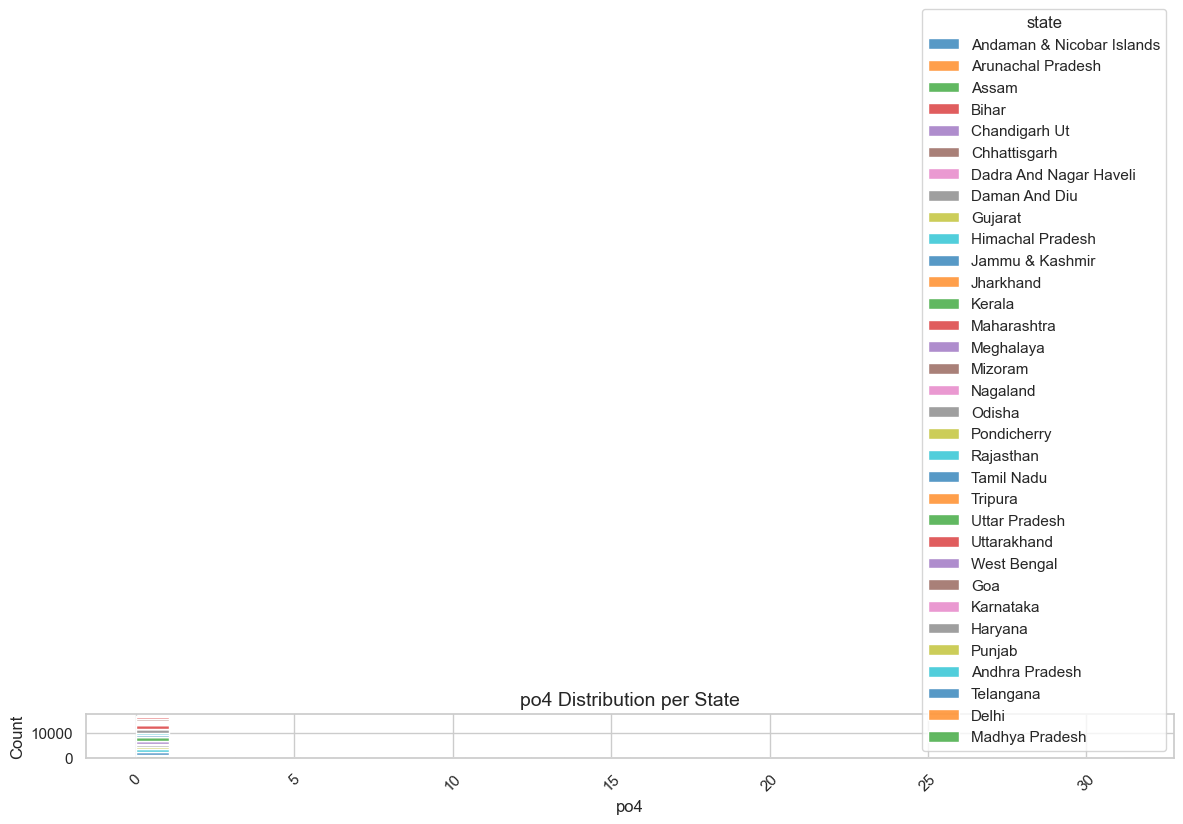

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


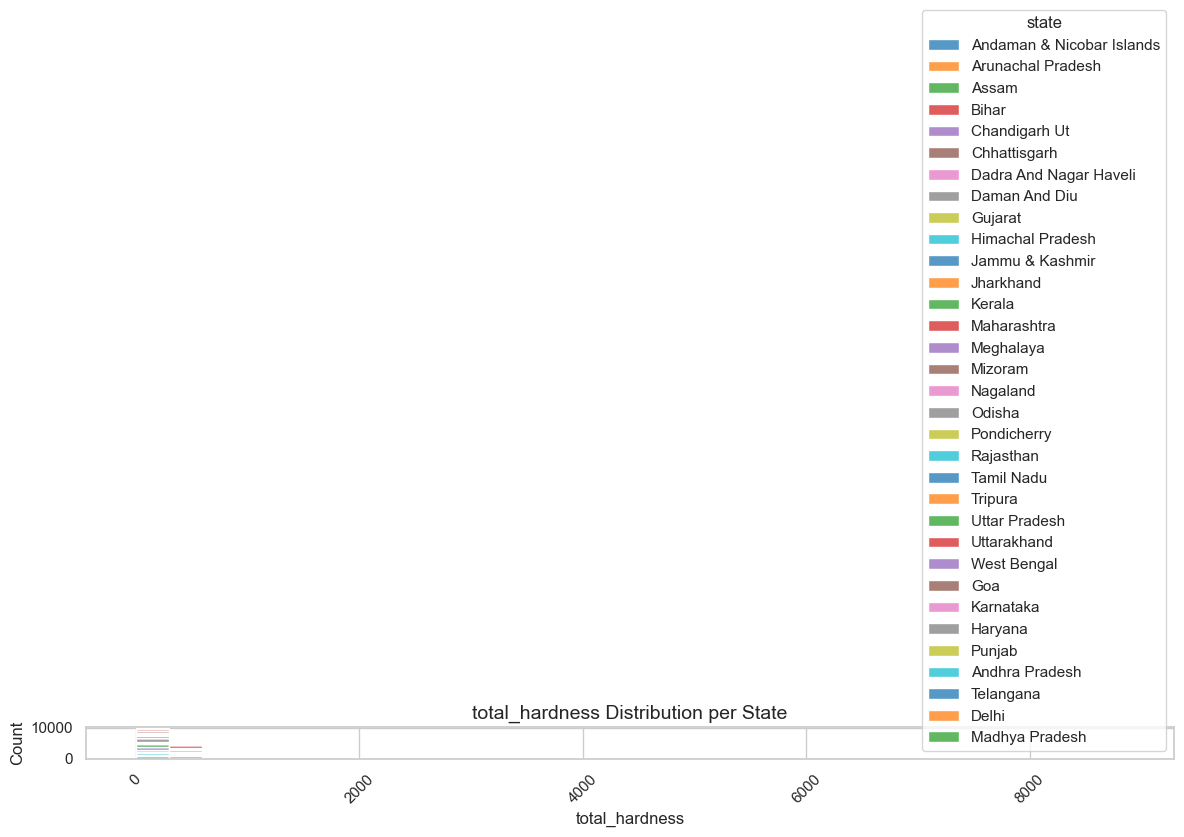

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


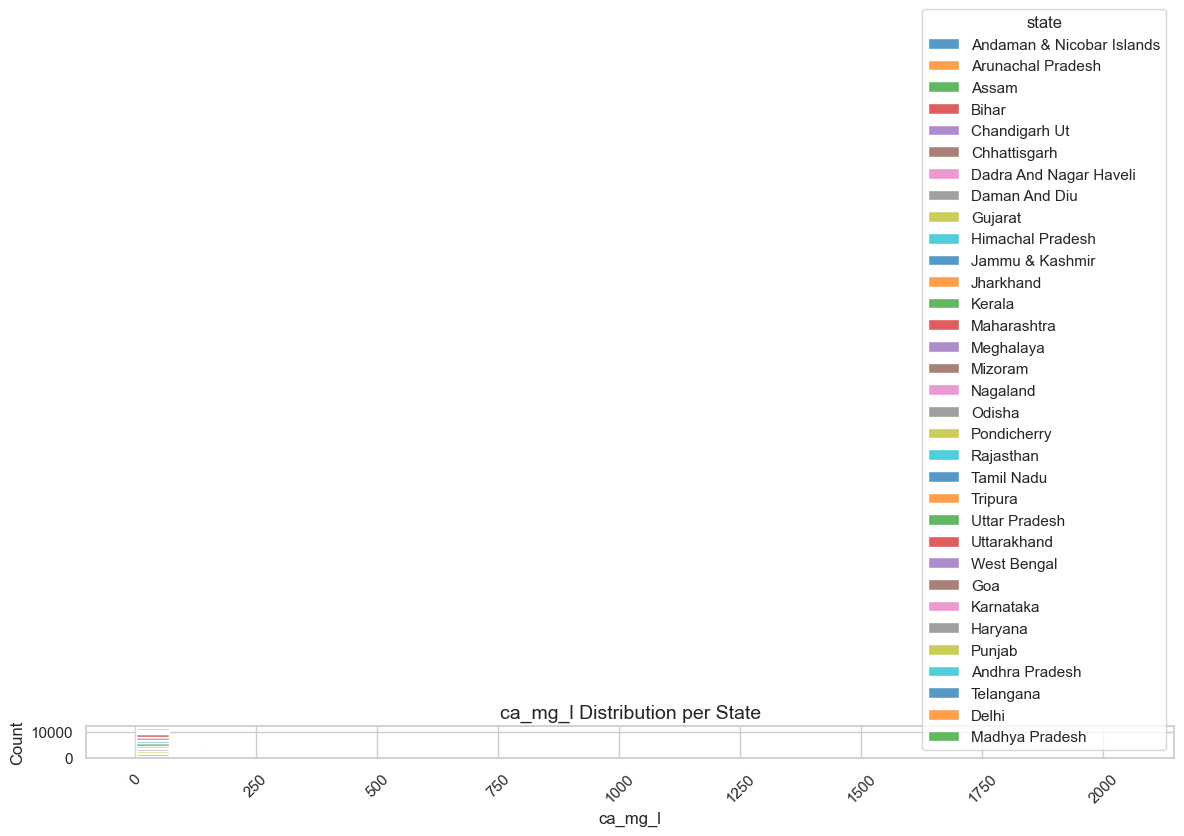

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


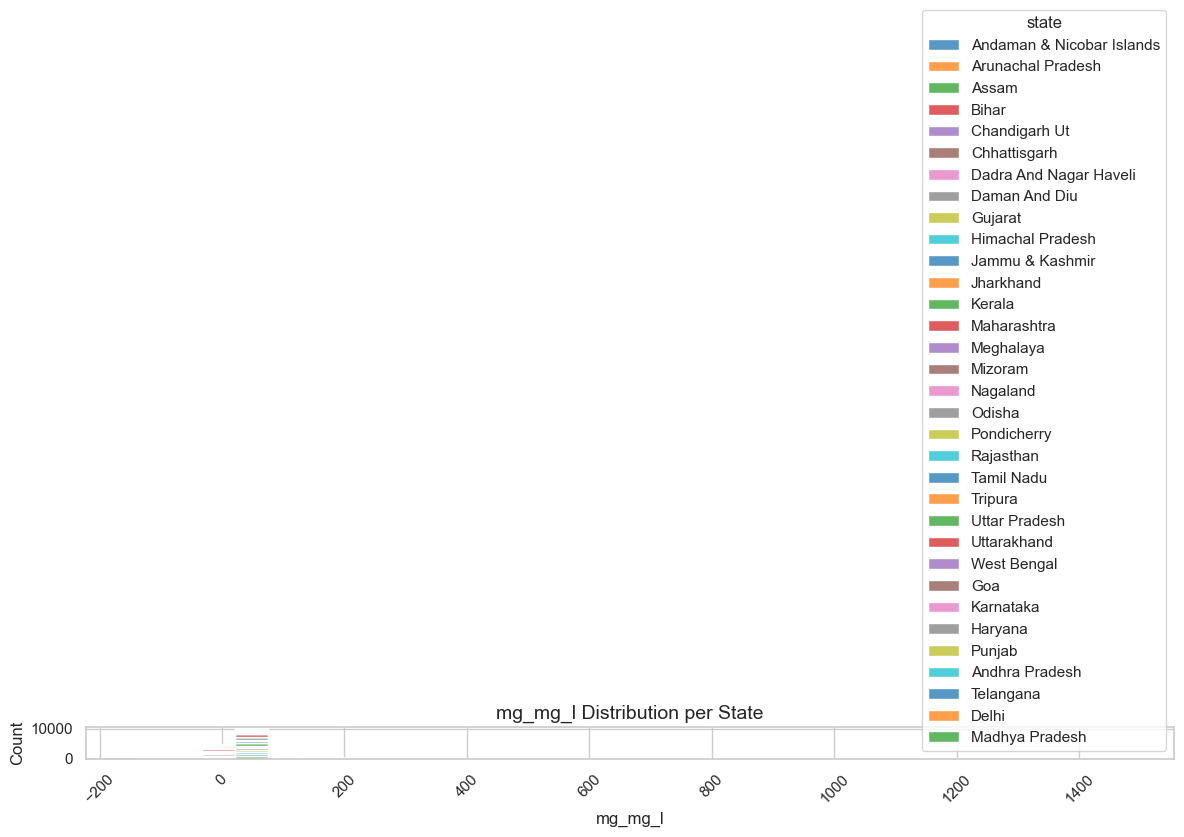

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


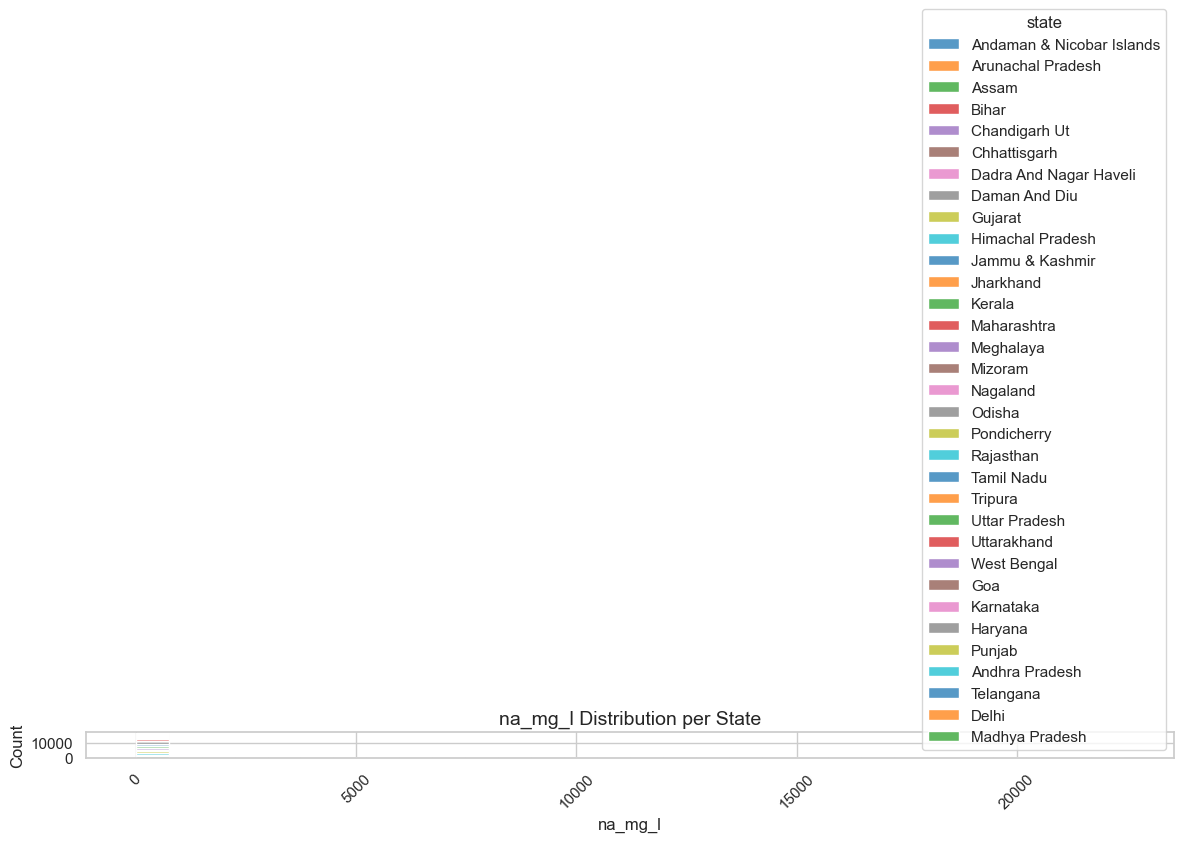

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


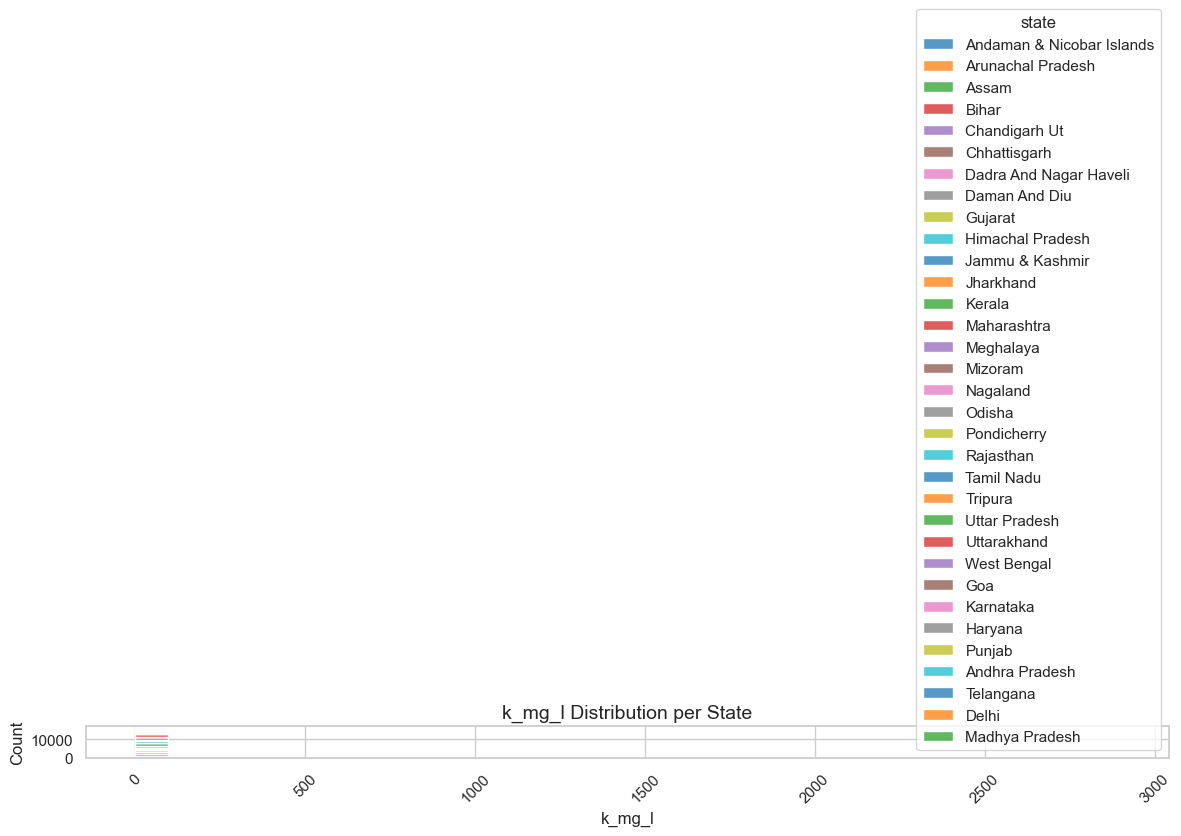

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


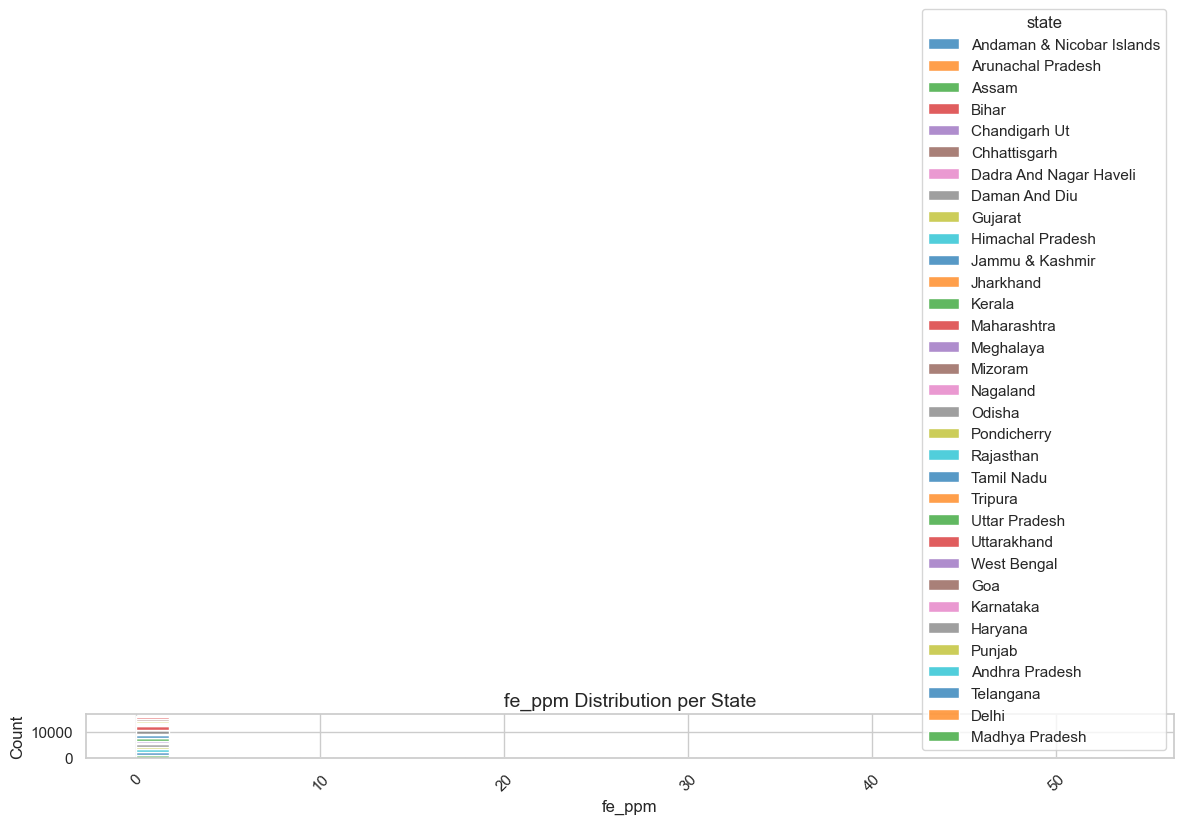

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


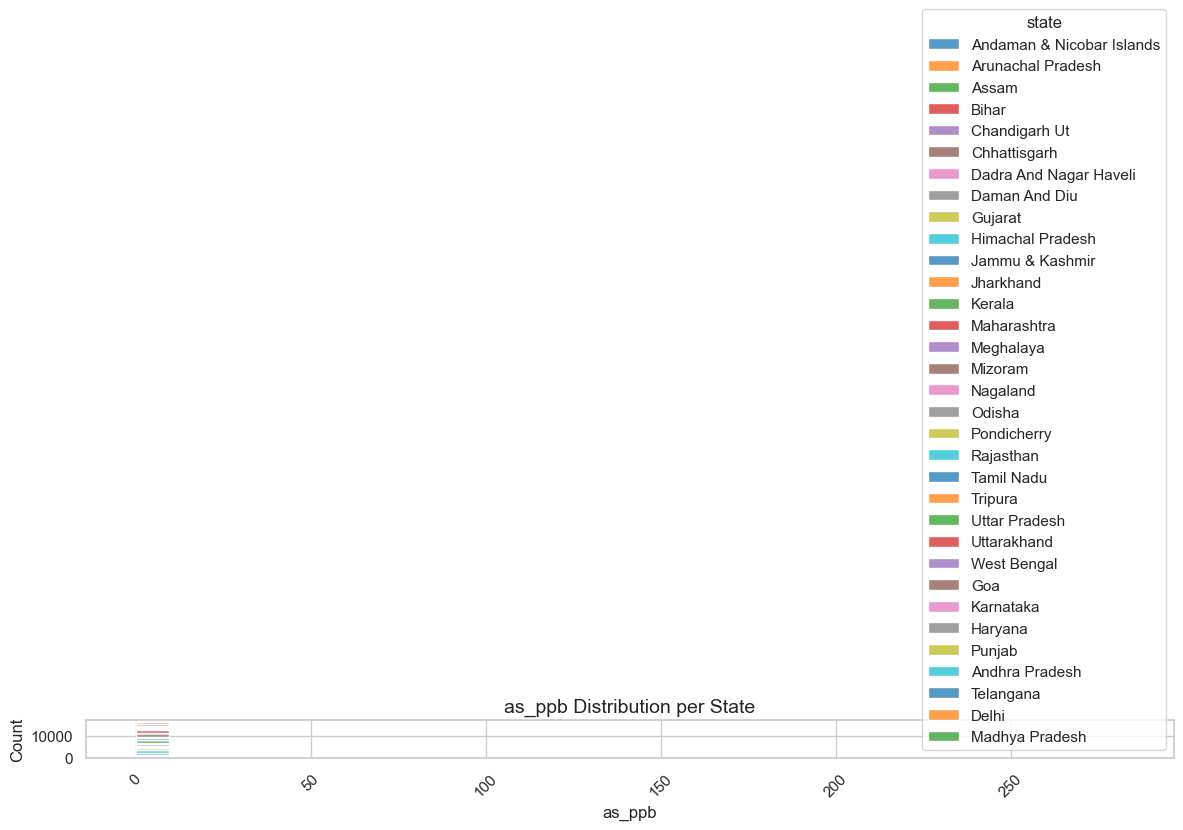

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


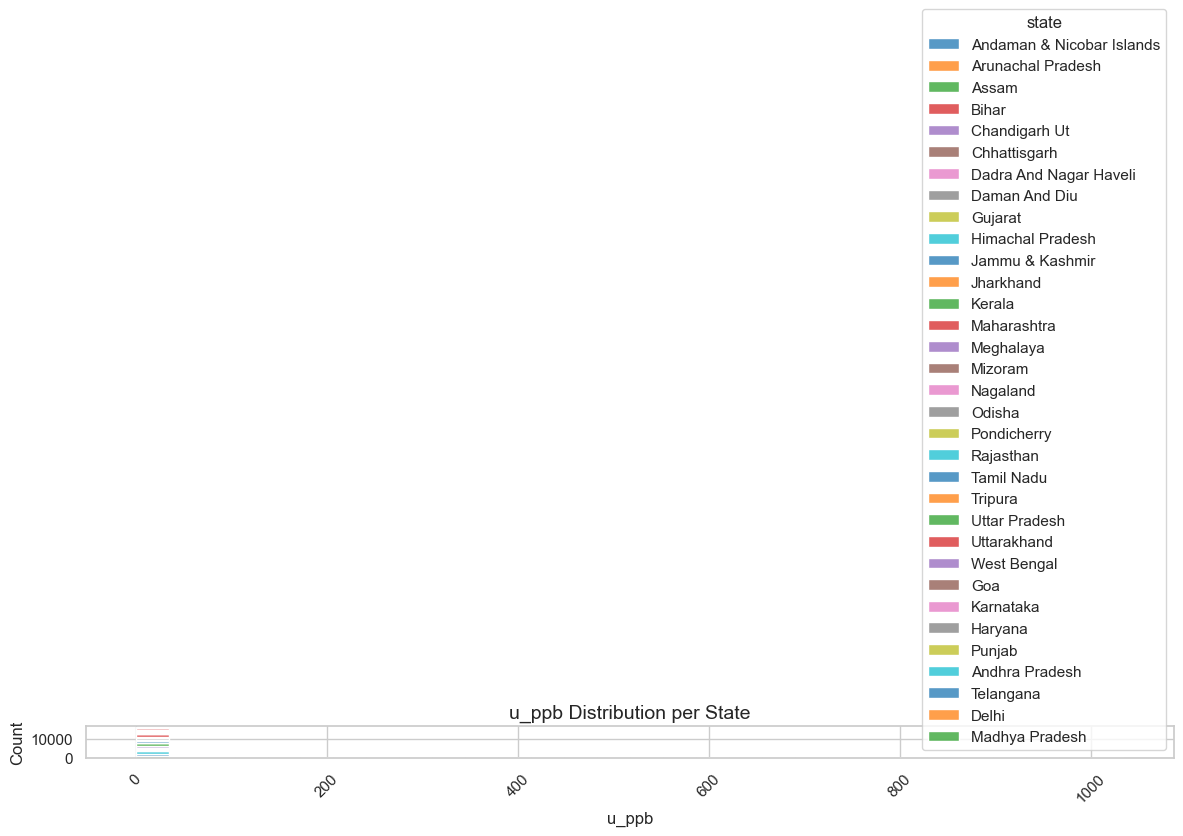

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


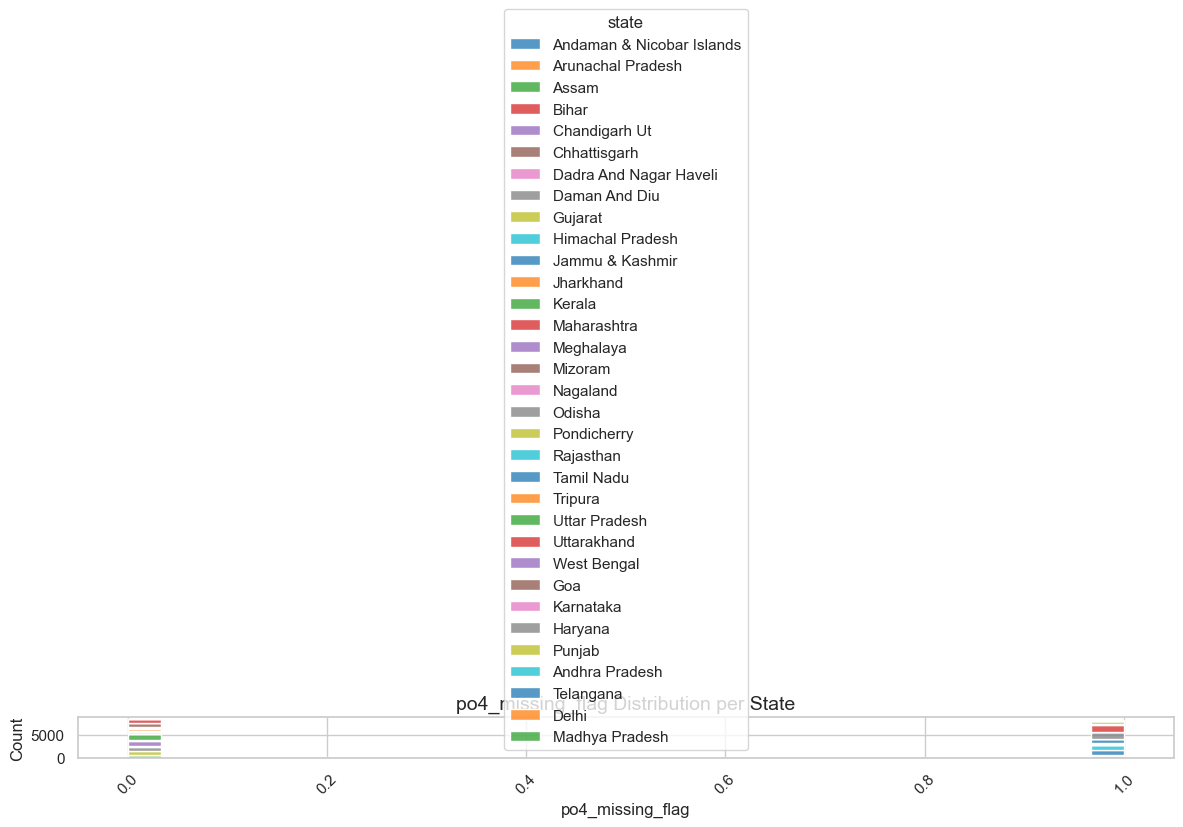

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


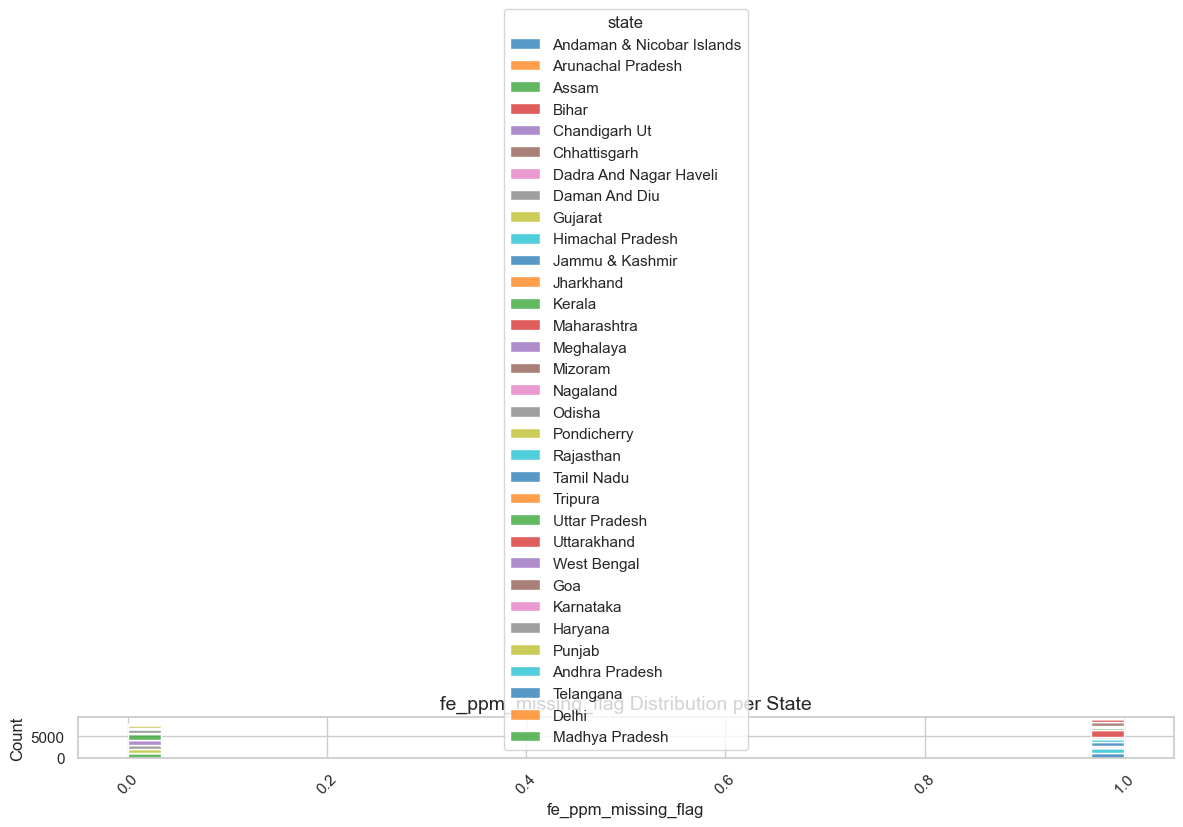

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


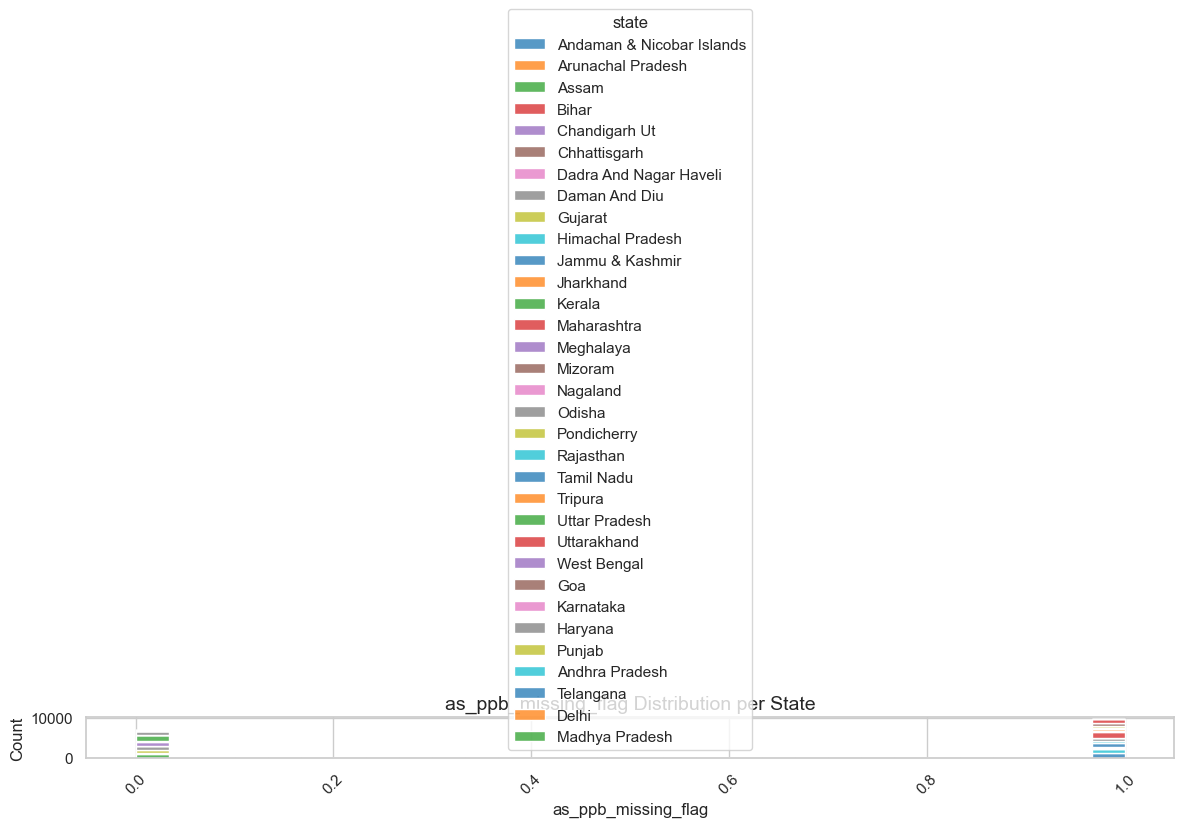

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


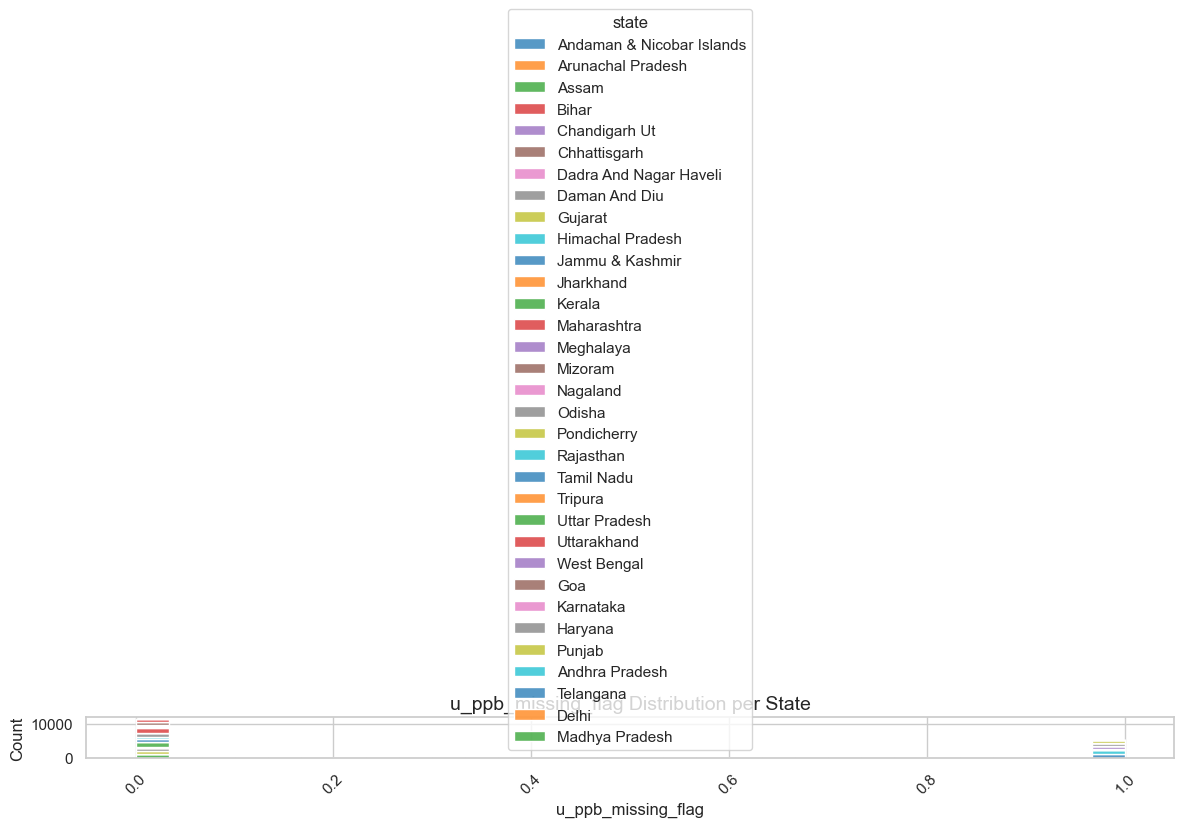

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:59: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)


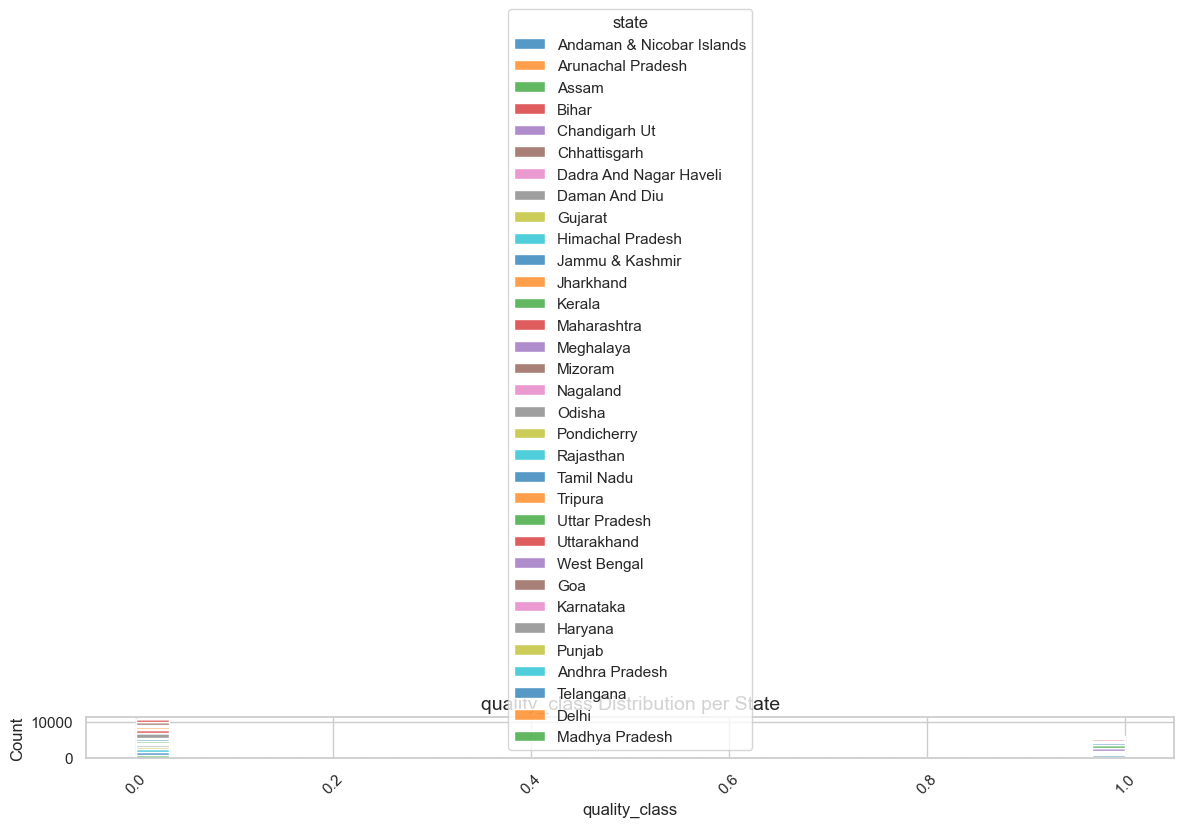

C:\Users\ABCD\AppData\Local\Temp\ipykernel_12964\3286214241.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="quality_class", palette=["green","red"])


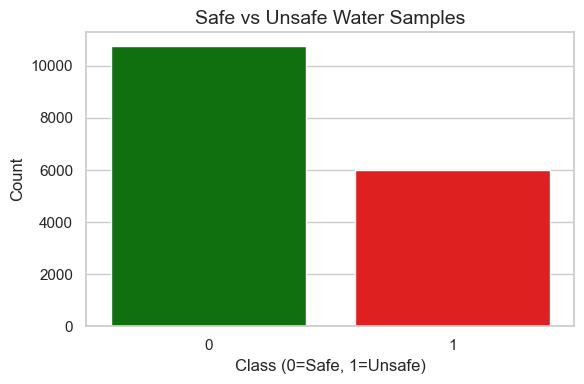

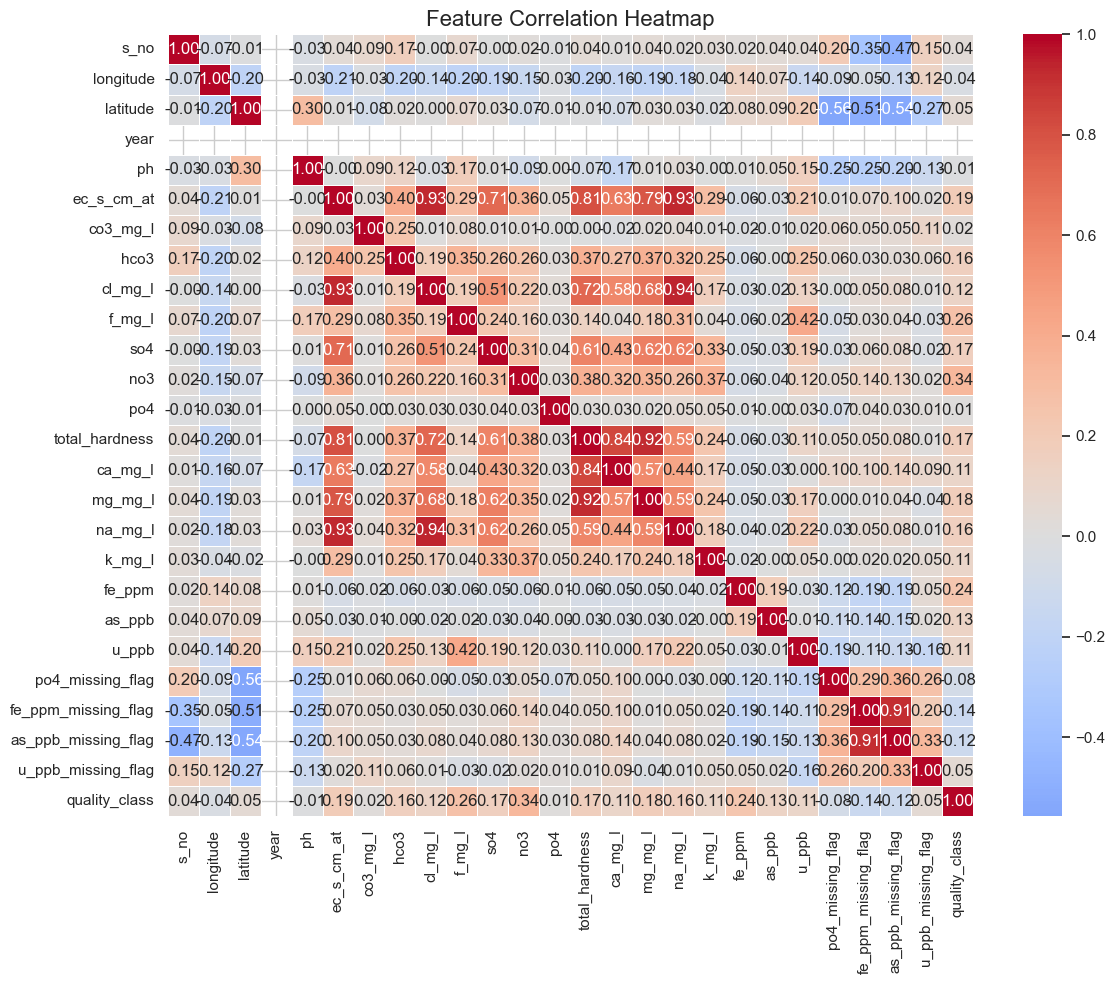

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("groundwater_cleaned_imputed.csv")

# -----------------------------
# Seaborn theme for plots
# -----------------------------
sns.set_theme(style="whitegrid")
palette = sns.color_palette("tab10")  # 10 distinct colors

# -----------------------------
# 1. Basic Info & Missing
# -----------------------------
print("\n🔹 Dataset shape:", df.shape)
print("\n🔹 Missing values (%):\n", df.isna().mean().round(3) * 100)

# -----------------------------
# 2. Statistical Summaries
# -----------------------------
num_cols = df.select_dtypes(include=np.number).columns
print("\n🔹 Statistical Summary:")
print(df[num_cols].describe().T)

# -----------------------------
# 3. Boxplots for Each Feature
# -----------------------------
for col in num_cols:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Boxplot of {col}", fontsize=14)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4. Histograms per Feature
# -----------------------------
for col in num_cols:
    plt.figure(figsize=(10,4))
    sns.histplot(df[col], bins=30, kde=True, color="salmon")
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 5. Distribution per State (if exists)
# -----------------------------
if "state" in df.columns:
    for col in num_cols:
        plt.figure(figsize=(12,5))
        sns.histplot(data=df, x=col, hue="state", multiple="stack", palette=palette, bins=30)
        plt.title(f"{col} Distribution per State", fontsize=14)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# -----------------------------
# 6. Target Distribution
# -----------------------------
if "quality_class" in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x="quality_class", palette=["green","red"])
    plt.title("Safe vs Unsafe Water Samples", fontsize=14)
    plt.xlabel("Class (0=Safe, 1=Unsafe)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 7. Correlation Heatmap
# -----------------------------
plt.figure(figsize=(12,10))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", center=0, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()
